In [1]:
from google.colab import drive
drive.mount("/content/drive") 

Mounted at /content/drive


# Gerekli Kütüphaneler


In [2]:
import pandas as pd
import numpy as np
import math
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import GRU, Dense
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Verileri Yükleme

In [3]:
cash_flow_train_df = pd.read_csv('/content/drive/MyDrive/data/cash_flow_train.csv')
brent_df = pd.read_csv('/content/drive/MyDrive/data/brent.csv')
depo_pump_imm_df = pd.read_csv('/content/drive/MyDrive/data/depo_pump_imm.csv')
otv_df = pd.read_csv('/content/drive/MyDrive/data/otv.csv')
platts_df = pd.read_csv('/content/drive/MyDrive/data/platts.csv')
usd_df = pd.read_csv('/content/drive/MyDrive/data/usd.csv')
volume_df = pd.read_csv('/content/drive/MyDrive/data/volume.csv')

! Test verileri kullanılmayacağından test verileri çıkarıldı.

In [4]:
train_df = cash_flow_train_df.copy()
train_df = train_df.iloc[:-70]

print("\nCopy DataFrame (after deleting last 70 rows):")
train_df


Copy DataFrame (after deleting last 70 rows):


Date  Total Inflows  Customers - DDS  Customers - EFT  \
0    2019-01-02   1.747050e+07        7718750.0     9.655500e+06   
1    2019-01-03   1.153048e+07        3431500.0     8.098978e+06   
2    2019-01-04   2.591328e+07       13775750.0     1.213753e+07   
3    2019-01-07   5.259345e+07       39041750.0     1.355170e+07   
4    2019-01-08   3.650429e+07       15137500.0     2.136679e+07   
..          ...            ...              ...              ...   
950  2022-10-20   1.501094e+08       67291750.0     6.288476e+07   
951  2022-10-21   1.125004e+08       22031250.0     6.691662e+07   
952  2022-10-24   4.340212e+08      145970250.0     1.589143e+08   
953  2022-10-25   2.442643e+08      142866500.0     7.828583e+07   
954  2022-10-26   1.225691e+08       62955500.0     4.866366e+07   

     T&S Collections    FX Sales  Other operations  Total Outflows  \
0       0.000000e+00         0.0           96250.0   -4.631593e+07   
1       0.000000e+00         0.0               0.0   -1.535349e+07   
2       0.000000e+00         0.0               0.0   -1.098651e+08   
3       0.000000e+00         0.0               0.0   -5.165489e+07   
4       0.000000e+00         0.0               0.0   -1.842178e+07   
..               ...         ...               ...             ...   
950     1.993287e+07         0.0               0.0   -5.388931e+07   
951     1.355248e+07         0.0        10000000.0   -2.601536e+08   
952     5.443866e+07  46073000.0        28625000.0   -4.983722e+08   
953     2.311200e+07         0.0               0.0   -1.601582e+08   
954     1.094990e+07         0.0               0.0   -1.117337e+08   

           Tüpraş     Other Oil           Gas  Import payments (FX purchases)  \
0   -1.457022e+07 -1.441510e+05 -1.109963e+06                     -29274250.0   
1   -1.337181e+07 -3.007992e+05 -2.798575e+05                         -7746.0   
2   -2.459390e+07  0.000000e+00  0.000000e+00                     -49032605.0   
3   -3.110594e+07 -3.364373e+06 -1.406590e+06                     -12049750.0   
4   -1.246099e+07 -1.676525e+04 -4.078995e+05                        -67702.5   
..            ...           ...           ...                             ...   
950 -3.992114e+07  0.000000e+00 -6.993916e+06                             0.0   
951 -1.123263e+08 -4.061403e+07 -8.967548e+06                     -93015000.0   
952 -2.458025e+08 -7.579164e+07 -1.825016e+07                             0.0   
953 -5.820062e+07 -2.159078e+07 -1.226339e+07                             0.0   
954 -3.722932e+07 -4.289275e+07 -5.133016e+06                      -8410500.0   

              Tax  Operatioınal and Admin. Expenses  VIS Buyback Payments  \
0   -1.048839e+05                     -1.112469e+06          0.000000e+00   
1   -7.887853e+05                     -6.044857e+05          0.000000e+00   
2   -2.936467e+06                     -7.175890e+06         -2.612621e+07   
3   -8.218624e+05                     -2.906375e+06          0.000000e+00   
4   -4.438174e+06                     -1.030241e+06          0.000000e+00   
..            ...                               ...                   ...   
950 -4.730528e+06                     -2.243729e+06          0.000000e+00   
951 -2.527291e+06                     -2.416891e+06         -2.865328e+05   
952 -2.774455e+05                     -5.898823e+06         -1.523516e+08   
953 -5.927282e+07                     -8.795721e+06         -3.490778e+04   
954 -1.278423e+07                     -5.283885e+06          0.000000e+00   

     Net Cashflow from Operations  Inflows- currency  
0                   -2.884543e+07                NaN  
1                   -3.823007e+06                NaN  
2                   -8.395180e+07                NaN  
3                    9.385578e+05                NaN  
4                    1.808252e+07                NaN  
..                            ...                ...  
950                  9.622006e+07         28910.0000  
951            

# Verilerin İncelenmesi

In [5]:
train_df

Date  Total Inflows  Customers - DDS  Customers - EFT  \
0    2019-01-02   1.747050e+07        7718750.0     9.655500e+06   
1    2019-01-03   1.153048e+07        3431500.0     8.098978e+06   
2    2019-01-04   2.591328e+07       13775750.0     1.213753e+07   
3    2019-01-07   5.259345e+07       39041750.0     1.355170e+07   
4    2019-01-08   3.650429e+07       15137500.0     2.136679e+07   
..          ...            ...              ...              ...   
950  2022-10-20   1.501094e+08       67291750.0     6.288476e+07   
951  2022-10-21   1.125004e+08       22031250.0     6.691662e+07   
952  2022-10-24   4.340212e+08      145970250.0     1.589143e+08   
953  2022-10-25   2.442643e+08      142866500.0     7.828583e+07   
954  2022-10-26   1.225691e+08       62955500.0     4.866366e+07   

     T&S Collections    FX Sales  Other operations  Total Outflows  \
0       0.000000e+00         0.0           96250.0   -4.631593e+07   
1       0.000000e+00         0.0               0.0   -1.535349e+07   
2       0.000000e+00         0.0               0.0   -1.098651e+08   
3       0.000000e+00         0.0               0.0   -5.165489e+07   
4       0.000000e+00         0.0               0.0   -1.842178e+07   
..               ...         ...               ...             ...   
950     1.993287e+07         0.0               0.0   -5.388931e+07   
951     1.355248e+07         0.0        10000000.0   -2.601536e+08   
952     5.443866e+07  46073000.0        28625000.0   -4.983722e+08   
953     2.311200e+07         0.0               0.0   -1.601582e+08   
954     1.094990e+07         0.0               0.0   -1.117337e+08   

           Tüpraş     Other Oil           Gas  Import payments (FX purchases)  \
0   -1.457022e+07 -1.441510e+05 -1.109963e+06                     -29274250.0   
1   -1.337181e+07 -3.007992e+05 -2.798575e+05                         -7746.0   
2   -2.459390e+07  0.000000e+00  0.000000e+00                     -49032605.0   
3   -3.110594e+07 -3.364373e+06 -1.406590e+06                     -12049750.0   
4   -1.246099e+07 -1.676525e+04 -4.078995e+05                        -67702.5   
..            ...           ...           ...                             ...   
950 -3.992114e+07  0.000000e+00 -6.993916e+06                             0.0   
951 -1.123263e+08 -4.061403e+07 -8.967548e+06                     -93015000.0   
952 -2.458025e+08 -7.579164e+07 -1.825016e+07                             0.0   
953 -5.820062e+07 -2.159078e+07 -1.226339e+07                             0.0   
954 -3.722932e+07 -4.289275e+07 -5.133016e+06                      -8410500.0   

              Tax  Operatioınal and Admin. Expenses  VIS Buyback Payments  \
0   -1.048839e+05                     -1.112469e+06          0.000000e+00   
1   -7.887853e+05                     -6.044857e+05          0.000000e+00   
2   -2.936467e+06                     -7.175890e+06         -2.612621e+07   
3   -8.218624e+05                     -2.906375e+06          0.000000e+00   
4   -4.438174e+06                     -1.030241e+06          0.000000e+00   
..            ...                               ...                   ...   
950 -4.730528e+06                     -2.243729e+06          0.000000e+00   
951 -2.527291e+06                     -2.416891e+06         -2.865328e+05   
952 -2.774455e+05                     -5.898823e+06         -1.523516e+08   
953 -5.927282e+07                     -8.795721e+06         -3.490778e+04   
954 -1.278423e+07                     -5.283885e+06          0.000000e+00   

     Net Cashflow from Operations  Inflows- currency  
0                   -2.884543e+07                NaN  
1                   -3.823007e+06                NaN  
2                   -8.395180e+07                NaN  
3                    9.385578e+05                NaN  
4                    1.808252e+07                NaN  
..                            ...                ...  
950                  9.622006e+07         28910.0000  
951            

In [6]:
brent_df

Tarih       Ürün Avrupa Birliği Para Birimi  AB Piyasa Fiyatı  \
0     2023-02-01  ICE BRENT                      $/BBL             82.84   
1     2023-01-31  ICE BRENT                      $/BBL             84.49   
2     2023-01-30  ICE BRENT                      $/BBL             84.90   
3     2023-01-29  ICE BRENT                      $/BBL             86.66   
4     2023-01-28  ICE BRENT                      $/BBL             86.66   
...          ...        ...                        ...               ...   
1852  2018-01-06  ICE BRENT                      $/BBL             67.62   
1853  2018-01-05  ICE BRENT                      $/BBL             67.62   
1854  2018-01-04  ICE BRENT                      $/BBL             68.07   
1855  2018-01-03  ICE BRENT                      $/BBL             67.84   
1856  2018-01-02  ICE BRENT                      $/BBL             66.57   

      AB Piyasa Fiyatı- Yüksek  AB Piyasa Fiyatı- Düşük  Dolar Kuru (Satış)  
0                        86.21                    82.37             18.8235  
1                        85.25                    83.73             18.8216  
2                        87.48                    84.66             18.8215  
3                        88.95                    85.69             18.8191  
4                        88.95                    85.69             18.8191  
...                        ...                      ...                 ...  
1852                     68.11                    67.26              3.7523  
1853                     68.11                    67.26              3.7523  
1854                     68.27                    67.62              3.7668  
1855                     67.94                    66.40              3.7685  
1856                     67.29                    66.24              3.7719  

[1857 rows x 7 columns]

In [7]:
depo_pump_imm_df

Yıl  Ay   IMM TL/m3 Pump Price  Depot Price
0   2018   1     596,79       5,28     4.149,81 
1   2018   2     606,58       5,23     4.110,32 
2   2018   3     610,44       5,32     4.195,51 
3   2018   4     608,02       5,62     4.449,25 
4   2018   5     574,56       5,77     4.605,51 
5   2018   6     566,88       5,85     4.654,05 
6   2018   7     568,14       5,85     4.653,43 
7   2018   8     578,37       6,14     4.895,90 
8   2018   9     626,97       6,46     5.141,45 
9   2018  10     676,90       6,52     5.183,54 
10  2018  11     711,11       6,41     5.126,19 
11  2018  12     717,18       5,98     4.774,72 
12  2019   1     723,05       6,02     4.784,03 
13  2019   2     723,29       6,16     4.924,61 
14  2019   3     724,89       6,45     5.158,59 
15  2019   4     741,79       6,58     5.258,89 
16  2019   5     739,02       6,64     5.300,94 
17  2019   6     790,24       6,52     5.199,24 
18  2019   7     810,47       6,59     5.253,09 
19  2019   8     829,02       6,38     5.038,32 
20  2019   9     832,98       6,58     5.223,69 
21  2019  10     841,94       6,63     5.262,43 
22  2019  11     846,15       6,67     5.291,59 
23  2019  12     854,30       6,66     5.277,54 
24  2020   1     863,25       6,68     5.308,16 
25  2020   2     873,64       6,50     5.138,24 
26  2020   3     894,27       5,82     4.549,79 
27  2020   4     922,12       5,23     4.063,43 
28  2020   5     945,60       5,43     4.218,53 
29  2020   6     817,29       5,81     4.597,30 
30  2020   7     818,27       6,10     4.821,35 
31  2020   8     828,31       6,27     4.953,49 
32  2020   9     844,58       6,16     4.850,69 
33  2020  10     855,14       6,31     4.949,01 
34  2020  11     877,74       6,47     5.086,74 
35  2020  12     913,90       6,80     5.320,65 
36  2021   1     929,34       6,84     5.347,71 
37  2021   2     940,33       6,85     5.353,49 
38  2021   3     865,08       6,77     5.324,00 
39  2021   4     764,48       6,65     5.267,92 
40  2021   5     817,68       7,05     5.496,82 
41  2021   6     874,84       7,44     5.872,81 
42  2021   7     887,42       7,47     5.889,00 
43  2021   8     878,52       7,48     5.987,74 
44  2021   9     885,21       7,49     5.911,61 
45  2021  10     898,18       7,89     6.265,89 
46  2021  11     920,00       8,60     6.917,02 
47  2021  12     963,06      10,63     8.688,64 
48  2022   1   1.025,74      13,77    11.221,90 
49  2022   2   1.081,41      15,33    12.547,69 
50  2022   3   1.260,11      19,89    16.938,64 
51  2022   4   1.391,19      21,00    17.167,27 
52  2022   5   1.428,25      22,43    18.322,91 
53  2022   6   1.506,08      27,69    23.049,58 
54  2022   7   1.597,06      25,20    20.562,96 
55  2022   8   1.641,60      23,61    19.358,23 
56  2022   9   1.703,10      23,15    18.880,31 
57  2022  10   1.773,62      24,77    20.379,60 
58  2022  11   1.827,06      24,47    19.948,92 
59  2022  12   1.926,96      21,23    17.233,08

In [8]:
otv_df

Tarih     ÖTV   Adet  ÖTV Oranı        ÖTV uygulanan Ürün Adı
0    2018-05-22  2124.10  1000    2.12410           Kursunsuz Benzin 95
1    2018-05-22  2124.10  1000    2.12410           Kursunsuz Benzin 95
2    2018-05-22  2081.62  1000    2.08162  Etanollü Kurşunsuz Benzin 95
3    2018-05-22  2081.62  1000    2.08162  Etanollü Kurşunsuz Benzin 95
4    2018-05-22  1567.90  1000    1.56790                       Motorin
..          ...      ...   ...        ...                           ...
412  2021-12-25  1778.00  1000    1.77800                           LPG
413  2022-03-01  2526.50  1000    2.52650           Kursunsuz Benzin 95
414  2022-03-01  2526.50  1000    2.52650           Kursunsuz Benzin 95
415  2022-03-01  2475.97  1000    2.47597  Etanollü Kurşunsuz Benzin 95
416  2022-03-01  2475.97  1000    2.47597  Etanollü Kurşunsuz Benzin 95

[417 rows x 5 columns]

In [9]:
platts_df

Tarih                                     Ürün  \
0     2022-12-31      10 ppm ULSD CIF Med (Genova/Lavera)   
1     2022-12-30      10 ppm ULSD CIF Med (Genova/Lavera)   
2     2022-12-29      10 ppm ULSD CIF Med (Genova/Lavera)   
3     2022-12-28      10 ppm ULSD CIF Med (Genova/Lavera)   
4     2022-12-27      10 ppm ULSD CIF Med (Genova/Lavera)   
...          ...                                      ...   
3645  2018-01-06  Prem Unl 10 ppm CIF Med (Genova/Lavera)   
3646  2018-01-05  Prem Unl 10 ppm CIF Med (Genova/Lavera)   
3647  2018-01-04  Prem Unl 10 ppm CIF Med (Genova/Lavera)   
3648  2018-01-03  Prem Unl 10 ppm CIF Med (Genova/Lavera)   
3649  2018-01-02  Prem Unl 10 ppm CIF Med (Genova/Lavera)   

     Avrupa Birliği Birimi  AB Piyasa Fiyatı  AB Piyasa Fiyatı- Yüksek  \
0                    $/TON            932.25                    932.50   
1                    $/TON            932.25                    932.50   
2                    $/TON            927.00                    927.25   
3                    $/TON            926.25                    926.50   
4                    $/TON            920.00                    920.25   
...                    ...               ...                       ...   
3645                 $/TON            628.50                    628.75   
3646                 $/TON            628.50                    628.75   
3647                 $/TON            633.25                    633.50   
3648                 $/TON            637.25                    637.50   
3649                 $/TON            632.75                    633.00   

      AB Piyasa Fiyatı- Düşük  Dolar Kuru (Satış)  
0                      932.00             18.7320  
1                      932.00             18.7320  
2                      926.75             18.7303  
3                      926.00             18.7301  
4                      919.75             18.7150  
...                       ...                 ...  
3645                   628.25              3.7523  
3646                   628.25              3.7523  
3647                   633.00              3.7668  
3648                   637.00              3.7685  
3649                   632.50              3.7719  

[3650 rows x 7 columns]

In [10]:
usd_df

Yıl       Tarih  USD ALIŞ  USD SATIŞ  EUR ALIŞ  EUR SATIŞ  GBP ALIŞ  \
0     2018  2018-01-02    3.7719     3.7787    4.5155     4.5237    5.0803   
1     2018  2018-01-03    3.7652     3.7719    4.5375     4.5457    5.0910   
2     2018  2018-01-04    3.7617     3.7685    4.5267     4.5349    5.1014   
3     2018  2018-01-05    3.7600     3.7668    4.5269     4.5351    5.0818   
4     2018  2018-01-06       NaN        NaN       NaN        NaN       NaN   
...    ...         ...       ...        ...       ...        ...       ...   
1852  2023  2023-01-28       NaN        NaN       NaN        NaN       NaN   
1853  2023  2023-01-29       NaN        NaN       NaN        NaN       NaN   
1854  2023  2023-01-30   18.7852    18.8191   20.4401    20.4769   23.2050   
1855  2023  2023-01-31   18.7876    18.8215   20.4525    20.4894   23.2356   
1856  2023  2023-02-01   18.7878    18.8216   20.3458    20.3824   23.1239   

      GBP SATIŞ  
0        5.1068  
1        5.1175  
2        5.1280  
3        5.1083  
4           NaN  
...         ...  
1852        NaN  
1853        NaN  
1854    23.3260  
1855    23.3568  
1856    23.2444  

[1857 rows x 8 columns]

In [11]:
volume_df

Posting date    Product                      Material Description  \
0        2019-01-01  400003756           BF AGO 10ppmS B0 Udy Mkd Turkey   
1        2019-01-01  400003769   SH ULG 95 10ppmS E0 Udy Mkd FuelSave TR   
2        2019-01-01  400003769   SH ULG 95 10ppmS E0 Udy Mkd FuelSave TR   
3        2019-01-01  400003981  AGO 10ppmS B0 Udy Mkd FuelSave Diesel TR   
4        2019-01-01  400003981  AGO 10ppmS B0 Udy Mkd FuelSave Diesel TR   
...             ...        ...                                       ...   
149369   2023-02-01  550063443             Spirax S2 A 80W-90_1*16L_A0S5   
149370   2023-02-01  550063444            Spirax S2 A 85W-140_1*16L_A0S5   
149371   2023-02-01  550063978                Spirax S5 DCT X_12*1L_A887   
149372   2023-02-01  550068415            RimR4X15W40CI4E7DH1_1*18L_A746   
149373   2023-02-01  550068417            RimR2 Extra20W50CF4_1*18L_A746   

                            Category  Sales Volumes in L15  
0                      Supply 310001           935955.0000  
1       Shell Fleet Solutions 100018               82.0275  
2                 Undercanopy 800001             2268.0725  
3       Shell Fleet Solutions 100018             4625.2275  
4                 Undercanopy 800001            39751.6400  
...                              ...                   ...  
149369             Lubricants 100034              640.0000  
149370             Lubricants 100034              316.0000  
149371             Lubricants 100034               21.0000  
149372             Lubricants 100034            17640.0000  
149373             Lubricants 100034            11074.5000  

[149374 rows x 5 columns]

# Eksik Değerleri Tespit Etme ve Gerekli Ön işlemleri Uygulama
* Enterpolasyon
* Boş verileri 0 ile doldurma
* Boş verileri silme

In [12]:
usd_df = usd_df.interpolate()

In [13]:
usd_df

Yıl       Tarih   USD ALIŞ  USD SATIŞ   EUR ALIŞ  EUR SATIŞ   GBP ALIŞ  \
0     2018  2018-01-02   3.771900   3.778700   4.515500   4.523700   5.080300   
1     2018  2018-01-03   3.765200   3.771900   4.537500   4.545700   5.091000   
2     2018  2018-01-04   3.761700   3.768500   4.526700   4.534900   5.101400   
3     2018  2018-01-05   3.760000   3.766800   4.526900   4.535100   5.081800   
4     2018  2018-01-06   3.755200   3.761967   4.522733   4.530933   5.076100   
...    ...         ...        ...        ...        ...        ...        ...   
1852  2023  2023-01-28  18.785267  18.819100  20.475433  20.512367  23.232333   
1853  2023  2023-01-29  18.785233  18.819100  20.457767  20.494633  23.218667   
1854  2023  2023-01-30  18.785200  18.819100  20.440100  20.476900  23.205000   
1855  2023  2023-01-31  18.787600  18.821500  20.452500  20.489400  23.235600   
1856  2023  2023-02-01  18.787800  18.821600  20.345800  20.382400  23.123900   

      GBP SATIŞ  
0      5.106800  
1      5.117500  
2      5.128000  
3      5.108300  
4      5.102567  
...         ...  
1852  23.353400  
1853  23.339700  
1854  23.326000  
1855  23.356800  
1856  23.244400  

[1857 rows x 8 columns]

In [14]:
missing_values_count = train_df.isnull().sum()
print("Missing Values in train_df:")
print(missing_values_count)

Missing Values in train_df:
Date                                  0
Total Inflows                         0
Customers - DDS                       0
Customers - EFT                       0
T&S Collections                       0
FX Sales                              0
Other operations                      0
Total Outflows                        0
Tüpraş                                0
Other Oil                             0
Gas                                   0
Import payments (FX purchases)        0
Tax                                   0
Operatioınal and Admin. Expenses      0
VIS Buyback Payments                  0
Net Cashflow from Operations          0
Inflows- currency                   501
dtype: int64


In [15]:
train_df = train_df.fillna(0)
train_df

Date  Total Inflows  Customers - DDS  Customers - EFT  \
0    2019-01-02   1.747050e+07        7718750.0     9.655500e+06   
1    2019-01-03   1.153048e+07        3431500.0     8.098978e+06   
2    2019-01-04   2.591328e+07       13775750.0     1.213753e+07   
3    2019-01-07   5.259345e+07       39041750.0     1.355170e+07   
4    2019-01-08   3.650429e+07       15137500.0     2.136679e+07   
..          ...            ...              ...              ...   
950  2022-10-20   1.501094e+08       67291750.0     6.288476e+07   
951  2022-10-21   1.125004e+08       22031250.0     6.691662e+07   
952  2022-10-24   4.340212e+08      145970250.0     1.589143e+08   
953  2022-10-25   2.442643e+08      142866500.0     7.828583e+07   
954  2022-10-26   1.225691e+08       62955500.0     4.866366e+07   

     T&S Collections    FX Sales  Other operations  Total Outflows  \
0       0.000000e+00         0.0           96250.0   -4.631593e+07   
1       0.000000e+00         0.0               0.0   -1.535349e+07   
2       0.000000e+00         0.0               0.0   -1.098651e+08   
3       0.000000e+00         0.0               0.0   -5.165489e+07   
4       0.000000e+00         0.0               0.0   -1.842178e+07   
..               ...         ...               ...             ...   
950     1.993287e+07         0.0               0.0   -5.388931e+07   
951     1.355248e+07         0.0        10000000.0   -2.601536e+08   
952     5.443866e+07  46073000.0        28625000.0   -4.983722e+08   
953     2.311200e+07         0.0               0.0   -1.601582e+08   
954     1.094990e+07         0.0               0.0   -1.117337e+08   

           Tüpraş     Other Oil           Gas  Import payments (FX purchases)  \
0   -1.457022e+07 -1.441510e+05 -1.109963e+06                     -29274250.0   
1   -1.337181e+07 -3.007992e+05 -2.798575e+05                         -7746.0   
2   -2.459390e+07  0.000000e+00  0.000000e+00                     -49032605.0   
3   -3.110594e+07 -3.364373e+06 -1.406590e+06                     -12049750.0   
4   -1.246099e+07 -1.676525e+04 -4.078995e+05                        -67702.5   
..            ...           ...           ...                             ...   
950 -3.992114e+07  0.000000e+00 -6.993916e+06                             0.0   
951 -1.123263e+08 -4.061403e+07 -8.967548e+06                     -93015000.0   
952 -2.458025e+08 -7.579164e+07 -1.825016e+07                             0.0   
953 -5.820062e+07 -2.159078e+07 -1.226339e+07                             0.0   
954 -3.722932e+07 -4.289275e+07 -5.133016e+06                      -8410500.0   

              Tax  Operatioınal and Admin. Expenses  VIS Buyback Payments  \
0   -1.048839e+05                     -1.112469e+06          0.000000e+00   
1   -7.887853e+05                     -6.044857e+05          0.000000e+00   
2   -2.936467e+06                     -7.175890e+06         -2.612621e+07   
3   -8.218624e+05                     -2.906375e+06          0.000000e+00   
4   -4.438174e+06                     -1.030241e+06          0.000000e+00   
..            ...                               ...                   ...   
950 -4.730528e+06                     -2.243729e+06          0.000000e+00   
951 -2.527291e+06                     -2.416891e+06         -2.865328e+05   
952 -2.774455e+05                     -5.898823e+06         -1.523516e+08   
953 -5.927282e+07                     -8.795721e+06         -3.490778e+04   
954 -1.278423e+07                     -5.283885e+06          0.000000e+00   

     Net Cashflow from Operations  Inflows- currency  
0                   -2.884543e+07             0.0000  
1                   -3.823007e+06             0.0000  
2                   -8.395180e+07             0.0000  
3                    9.385578e+05             0.0000  
4                    1.808252e+07             0.0000  
..                            ...                ...  
950                  9.622006e+07         28910.0000  
951            

In [16]:
missing_values_count = brent_df.isnull().sum()
print("Missing Values in brent_df:")
print(missing_values_count)


Missing Values in brent_df:
Tarih                          0
Ürün                           0
Avrupa Birliği Para Birimi     0
AB Piyasa Fiyatı               0
AB Piyasa Fiyatı- Yüksek      44
AB Piyasa Fiyatı- Düşük       44
Dolar Kuru (Satış)             0
dtype: int64


In [17]:
brent_df = brent_df.dropna()

In [18]:
brent_df

Tarih       Ürün Avrupa Birliği Para Birimi  AB Piyasa Fiyatı  \
0     2023-02-01  ICE BRENT                      $/BBL             82.84   
1     2023-01-31  ICE BRENT                      $/BBL             84.49   
2     2023-01-30  ICE BRENT                      $/BBL             84.90   
3     2023-01-29  ICE BRENT                      $/BBL             86.66   
4     2023-01-28  ICE BRENT                      $/BBL             86.66   
...          ...        ...                        ...               ...   
1852  2018-01-06  ICE BRENT                      $/BBL             67.62   
1853  2018-01-05  ICE BRENT                      $/BBL             67.62   
1854  2018-01-04  ICE BRENT                      $/BBL             68.07   
1855  2018-01-03  ICE BRENT                      $/BBL             67.84   
1856  2018-01-02  ICE BRENT                      $/BBL             66.57   

      AB Piyasa Fiyatı- Yüksek  AB Piyasa Fiyatı- Düşük  Dolar Kuru (Satış)  
0                        86.21                    82.37             18.8235  
1                        85.25                    83.73             18.8216  
2                        87.48                    84.66             18.8215  
3                        88.95                    85.69             18.8191  
4                        88.95                    85.69             18.8191  
...                        ...                      ...                 ...  
1852                     68.11                    67.26              3.7523  
1853                     68.11                    67.26              3.7523  
1854                     68.27                    67.62              3.7668  
1855                     67.94                    66.40              3.7685  
1856                     67.29                    66.24              3.7719  

[1813 rows x 7 columns]

In [19]:
missing_values_count = depo_pump_imm_df.isnull().sum()
print("Missing Values in depo_pump_imm_df:")
print(missing_values_count)

Missing Values in depo_pump_imm_df:
Yıl            0
Ay             0
IMM TL/m3      0
Pump Price     0
Depot Price    0
dtype: int64


In [20]:
missing_values_count = otv_df.isnull().sum()
print("Missing Values in otv_df:")
print(missing_values_count)

Missing Values in otv_df:
Tarih                     0
ÖTV                       0
Adet                      0
ÖTV Oranı                 0
ÖTV uygulanan Ürün Adı    0
dtype: int64


In [21]:
missing_values_count = platts_df.isnull().sum()
print("Missing Values in platts_df:")
print(missing_values_count)

Missing Values in platts_df:
Tarih                       0
Ürün                        0
Avrupa Birliği Birimi       0
AB Piyasa Fiyatı            0
AB Piyasa Fiyatı- Yüksek    0
AB Piyasa Fiyatı- Düşük     0
Dolar Kuru (Satış)          0
dtype: int64


In [22]:
missing_values_count = volume_df.isnull().sum()
print("Missing Values in volume_df:")
print(missing_values_count)

Missing Values in volume_df:
Posting date            0
Product                 0
Material Description    0
Category                0
Sales Volumes in L15    0
dtype: int64


Tarih sütunu her csv dosyasında bulunduğundan ve birleştirme gibi işlemler yapılacağından ortak bir ada sahip olunmalıydı. Tarih ile alaklı bütün sütunlar Tarih başlığı ile değiştirildi.

In [23]:
train_df = train_df.rename(columns={'Date': 'Tarih'})


In [24]:
depo_pump_imm_df['Tarih'] = pd.to_datetime(depo_pump_imm_df['Yıl'].astype(str) + '-' + depo_pump_imm_df['Ay'].astype(str))

depo_pump_imm_df = depo_pump_imm_df.drop(['Yıl', 'Ay'], axis=1)

print(depo_pump_imm_df)

     IMM TL/m3 Pump Price  Depot Price      Tarih
0      596,79       5,28     4.149,81  2018-01-01
1      606,58       5,23     4.110,32  2018-02-01
2      610,44       5,32     4.195,51  2018-03-01
3      608,02       5,62     4.449,25  2018-04-01
4      574,56       5,77     4.605,51  2018-05-01
5      566,88       5,85     4.654,05  2018-06-01
6      568,14       5,85     4.653,43  2018-07-01
7      578,37       6,14     4.895,90  2018-08-01
8      626,97       6,46     5.141,45  2018-09-01
9      676,90       6,52     5.183,54  2018-10-01
10     711,11       6,41     5.126,19  2018-11-01
11     717,18       5,98     4.774,72  2018-12-01
12     723,05       6,02     4.784,03  2019-01-01
13     723,29       6,16     4.924,61  2019-02-01
14     724,89       6,45     5.158,59  2019-03-01
15     741,79       6,58     5.258,89  2019-04-01
16     739,02       6,64     5.300,94  2019-05-01
17     790,24       6,52     5.199,24  2019-06-01
18     810,47       6,59     5.253,09  2019-07-01


In [25]:
volume_df = volume_df.rename(columns={'Posting date': 'Tarih'})
volume_df

Tarih    Product                      Material Description  \
0       2019-01-01  400003756           BF AGO 10ppmS B0 Udy Mkd Turkey   
1       2019-01-01  400003769   SH ULG 95 10ppmS E0 Udy Mkd FuelSave TR   
2       2019-01-01  400003769   SH ULG 95 10ppmS E0 Udy Mkd FuelSave TR   
3       2019-01-01  400003981  AGO 10ppmS B0 Udy Mkd FuelSave Diesel TR   
4       2019-01-01  400003981  AGO 10ppmS B0 Udy Mkd FuelSave Diesel TR   
...            ...        ...                                       ...   
149369  2023-02-01  550063443             Spirax S2 A 80W-90_1*16L_A0S5   
149370  2023-02-01  550063444            Spirax S2 A 85W-140_1*16L_A0S5   
149371  2023-02-01  550063978                Spirax S5 DCT X_12*1L_A887   
149372  2023-02-01  550068415            RimR4X15W40CI4E7DH1_1*18L_A746   
149373  2023-02-01  550068417            RimR2 Extra20W50CF4_1*18L_A746   

                            Category  Sales Volumes in L15  
0                      Supply 310001           935955.0000  
1       Shell Fleet Solutions 100018               82.0275  
2                 Undercanopy 800001             2268.0725  
3       Shell Fleet Solutions 100018             4625.2275  
4                 Undercanopy 800001            39751.6400  
...                              ...                   ...  
149369             Lubricants 100034              640.0000  
149370             Lubricants 100034              316.0000  
149371             Lubricants 100034               21.0000  
149372             Lubricants 100034            17640.0000  
149373             Lubricants 100034            11074.5000  

[149374 rows x 5 columns]

# Dağılım Grafikleri

In [26]:
fig = px.histogram(train_df, x="Tarih", y="Total Inflows", color="Total Outflows", marginal="box")

fig.update_layout(title="Distribution of Total Inflows and Total Outflows",
                  xaxis_title="Tarih",
                  yaxis_title="Total Inflows")

fig.show()


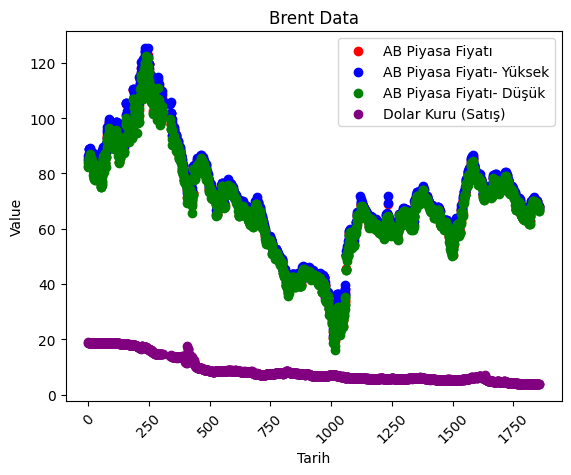

In [27]:
date = brent_df.index
eu_currency = brent_df['Avrupa Birliği Para Birimi']
eu_market_price = brent_df['AB Piyasa Fiyatı']
eu_market_price_high = brent_df['AB Piyasa Fiyatı- Yüksek']
eu_market_price_low = brent_df['AB Piyasa Fiyatı- Düşük']
dollar_rate = brent_df['Dolar Kuru (Satış)']

plt.scatter(date, eu_market_price, c='red', label='AB Piyasa Fiyatı')
plt.scatter(date, eu_market_price_high, c='blue', label='AB Piyasa Fiyatı- Yüksek')
plt.scatter(date, eu_market_price_low, c='green', label='AB Piyasa Fiyatı- Düşük')
plt.scatter(date, dollar_rate, c='purple', label='Dolar Kuru (Satış)')

plt.xlabel('Tarih')
plt.ylabel('Value')
plt.title('Brent Data')
plt.xticks(rotation=45)
plt.legend()

plt.show()


In [28]:
fig = px.histogram(depo_pump_imm_df, x="IMM TL/m3", y="Pump Price", color="Depot Price", marginal="rug")

fig.update_layout(title="Distribution of IMM TL/m3, Pump Price, and Depot Price",
                  xaxis_title="IMM TL/m3",
                  yaxis_title="Pump Price")

fig.show()


In [29]:
fig = px.scatter(otv_df, x='Tarih', y='ÖTV ', hover_data=['ÖTV Oranı', 'ÖTV uygulanan Ürün Adı'])

fig.update_layout(title="Interactive Scatter Plot",
                  xaxis_title="Tarih",
                  yaxis_title="ÖTV",
                  hovermode="closest")

fig.show()




In [30]:
platts_df.columns = platts_df.columns.str.strip()

fig = px.scatter(platts_df, x='Tarih', y='AB Piyasa Fiyatı', color='Ürün',
                 hover_data=['Tarih', 'Ürün', 'Avrupa Birliği Birimi', 'AB Piyasa Fiyatı', 'AB Piyasa Fiyatı- Yüksek', 'AB Piyasa Fiyatı- Düşük', 'Dolar Kuru (Satış)'])

fig.update_layout(title="Interactive Scatter Plot",
                  xaxis_title="Tarih",
                  yaxis_title="AB Piyasa Fiyatı",
                  hovermode="closest")

fig.show()


In [31]:
usd_df.columns = usd_df.columns.str.strip()

fig = px.scatter(usd_df, x='Tarih', y='USD SATIŞ', color='Yıl',
                 hover_data=['Yıl', 'Tarih', 'USD ALIŞ', 'USD SATIŞ', 'EUR ALIŞ', 'EUR SATIŞ', 'GBP ALIŞ', 'GBP SATIŞ'])

fig.update_layout(title="Interactive Scatter Plot",
                  xaxis_title="Tarih",
                  yaxis_title="USD SATIŞI",
                  hovermode="closest")

fig.show()


In [32]:
fig = px.scatter(volume_df, x='Tarih', y='Sales Volumes in L15', color='Product',
                 hover_data=['Tarih', 'Product', 'Material Description', 'Category', 'Sales Volumes in L15'])

fig.update_layout(title="Interactive Scatter Plot",
                  xaxis_title="Tarih",
                  yaxis_title="Sales Volumes in L15",
                  hovermode="closest")

fig.show()


Output hidden; open in https://colab.research.google.com to view.

# Numerik Değişken Dağılımları

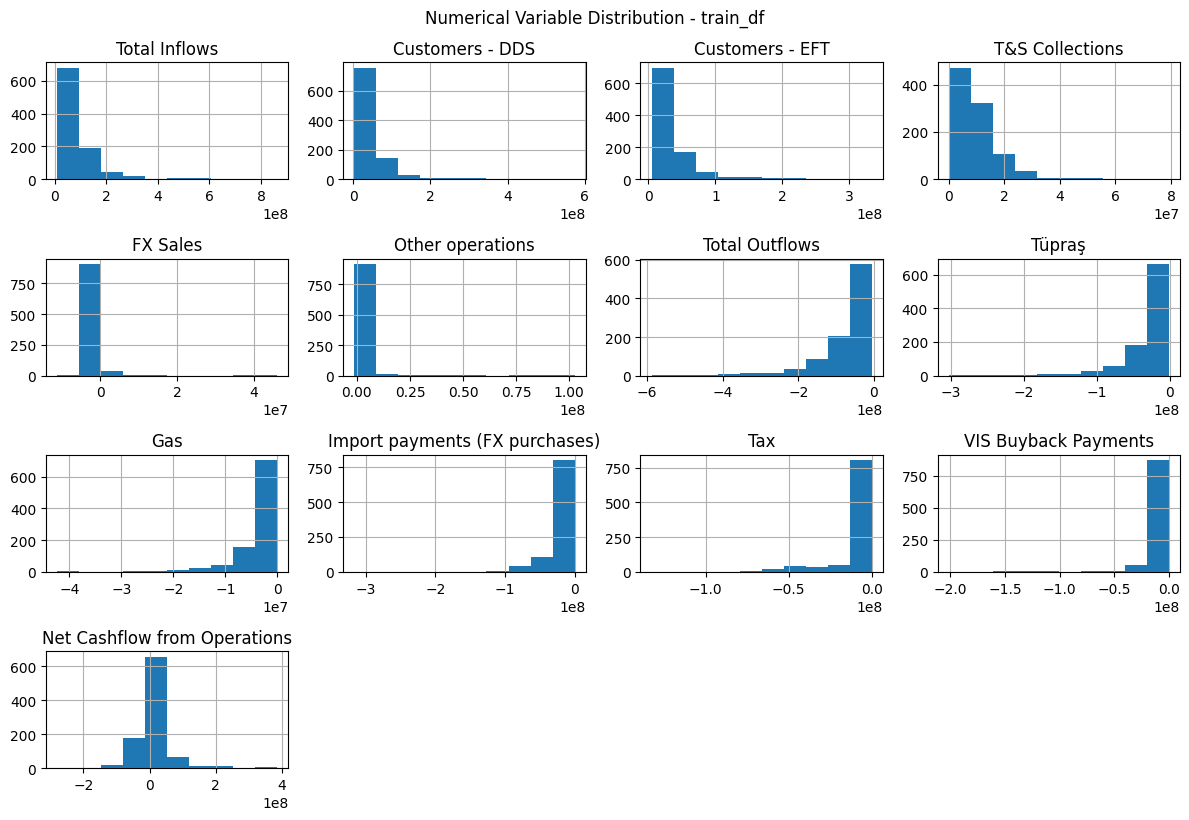

In [33]:
numerical_columns = ['Total Inflows', 'Customers - DDS', 'Customers - EFT', 'T&S Collections',
                     'FX Sales', 'Other operations', 'Total Outflows', 'Tüpraş', 
                     'Gas', 'Import payments (FX purchases)', 'Tax',
                     'VIS Buyback Payments', 'Net Cashflow from Operations']

train_df[numerical_columns].hist(figsize=(12, 8))
plt.tight_layout()

plt.xlabel('Value')
plt.suptitle('Numerical Variable Distribution - train_df', y=1.02)

plt.show()


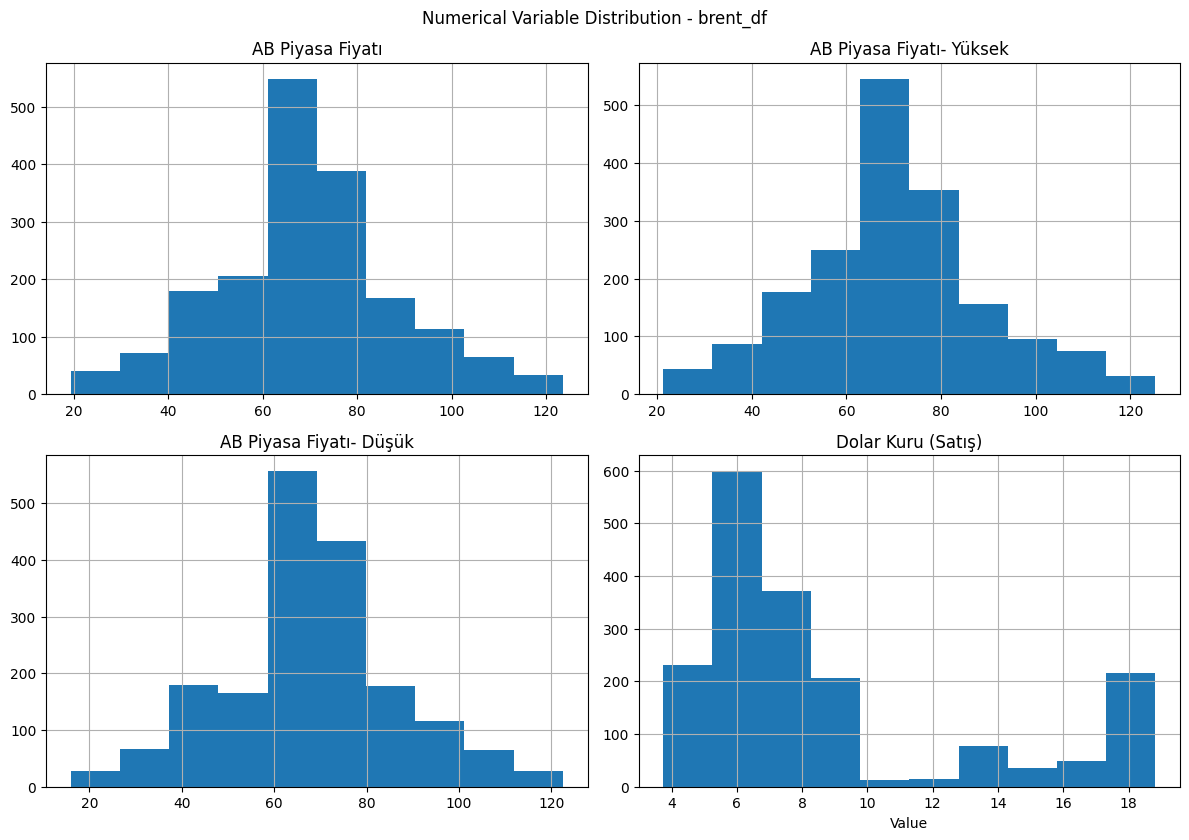

In [34]:
columns = ['AB Piyasa Fiyatı', 'AB Piyasa Fiyatı- Yüksek', 'AB Piyasa Fiyatı- Düşük', 'Dolar Kuru (Satış)']

brent_df[columns].hist(figsize=(12, 8))
plt.tight_layout()

plt.xlabel('Value')
plt.suptitle('Numerical Variable Distribution - brent_df', y=1.02)
plt.show()


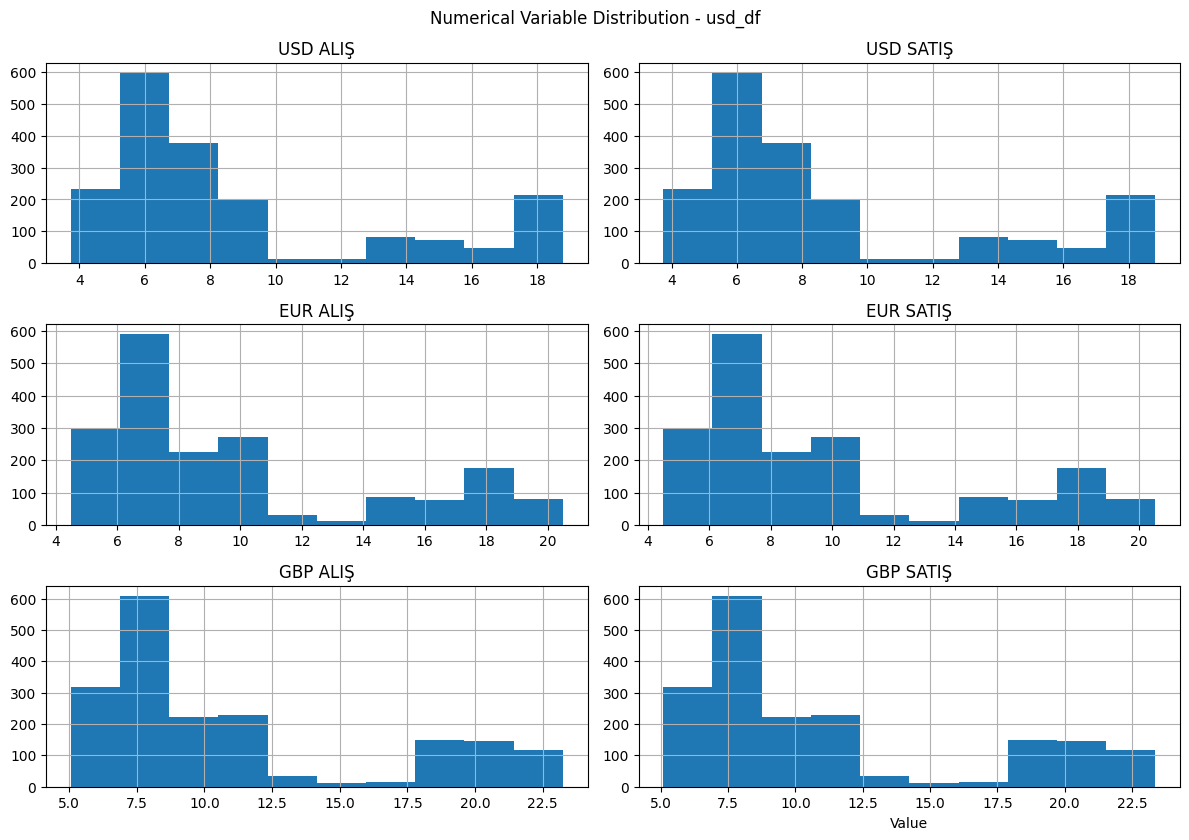

In [35]:
columns = ['USD ALIŞ', 'USD SATIŞ', 'EUR ALIŞ', 'EUR SATIŞ', 'GBP ALIŞ', 'GBP SATIŞ']

usd_df[columns].hist(figsize=(12, 8))
plt.tight_layout()

plt.xlabel('Value')
plt.suptitle('Numerical Variable Distribution - usd_df', y=1.02)
plt.show()


# Aykırı Değerleri Tespit Etme

In [36]:

def detect_outliers_and_boxplot(dataframe):
    # Check if dataframe is empty
    if dataframe.empty:
        print("No data in the dataframe.")
        return

    # Select columns with string values
    string_columns = dataframe.select_dtypes(include='object').columns

    # Remove commas from string columns and convert to numeric data types
    dataframe[string_columns] = dataframe[string_columns].apply(lambda x: pd.to_numeric(x.str.replace(',', ''), errors='ignore'))

    # Select numerical columns
    numerical_columns = dataframe.select_dtypes(include='number').columns

    # Check if there are missing values in numerical columns
    if dataframe[numerical_columns].isnull().values.any():
        print("Missing values in numerical columns.")
        return

    # Check if dataframe has at least one row
    if dataframe.shape[0] == 0:
        print("No data in the dataframe.")
        return

    # Calculate the number of rows and columns for the subplots
    num_plots = len(numerical_columns)
    num_rows = math.ceil(num_plots / 2)
    num_cols = 2 if num_plots >= 2 else 1

    # Create subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(6, 2*num_rows))

    # Flatten axs if necessary
    if num_rows > 1:
        axs = axs.flatten()

    # Detect outliers and plot boxplots
    for i, col in enumerate(numerical_columns):
        ax = axs[i]
        outliers = dataframe[(dataframe[col] < dataframe[col].quantile(0.25) - 1.5*(dataframe[col].quantile(0.75)-dataframe[col].quantile(0.25))) |
                             (dataframe[col] > dataframe[col].quantile(0.75) + 1.5*(dataframe[col].quantile(0.75)-dataframe[col].quantile(0.25)))]

        ax.boxplot(dataframe[col], vert=False)
        ax.set_title(col + ' Outliers')

        # Remove x-axis labels for all but the bottom row
        if i < num_plots - num_cols:
            ax.set_xticklabels([])

    # Hide empty subplots if necessary
    for i in range(num_plots, len(axs)):
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


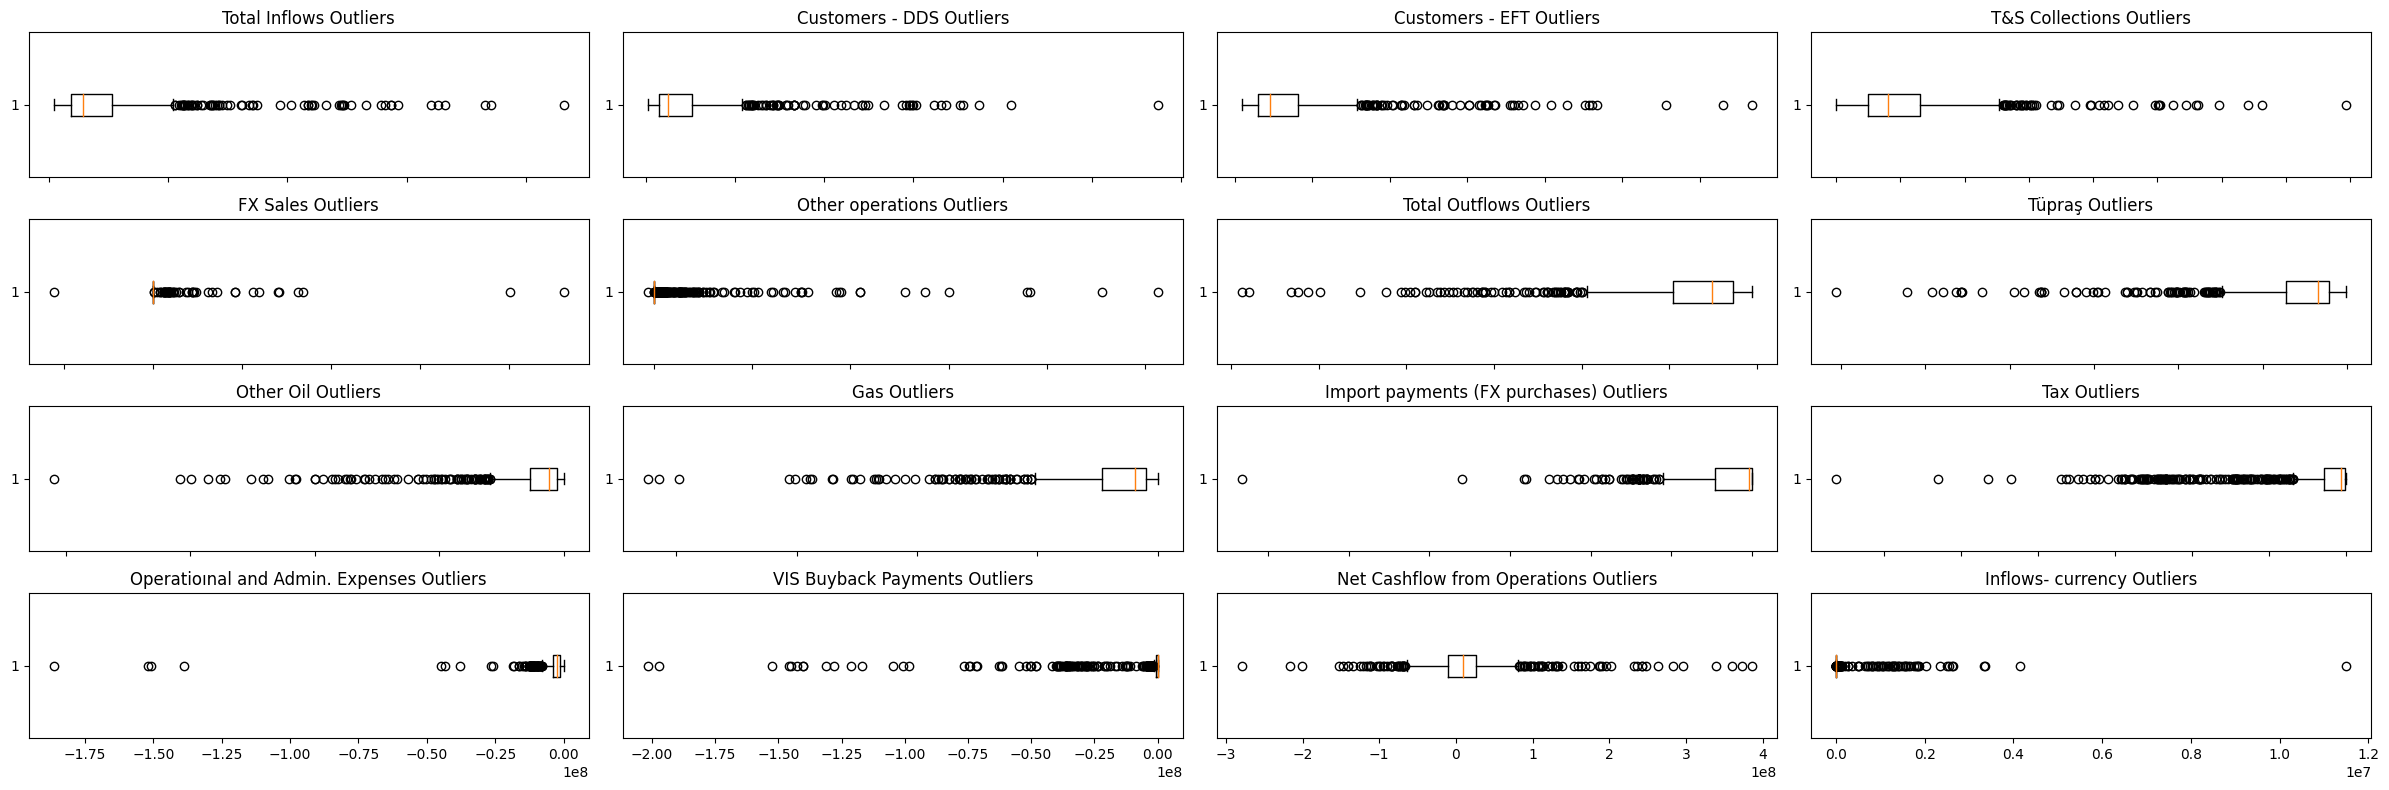

In [37]:

def detect_outliers_and_boxplot_(dataframe):
    # Select numerical columns
    numerical_columns = dataframe.select_dtypes(include='number').columns

    # Detect outliers
    outliers = {}
    for col in numerical_columns:
        q1 = dataframe[col].quantile(0.25)
        q3 = dataframe[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers[col] = dataframe[(dataframe[col] < lower_bound) | (dataframe[col] > upper_bound)][col]

    # Calculate the number of rows and columns for the subplots
    num_plots = len(outliers)
    num_rows = math.ceil(num_plots / 4)
    num_cols = 4 if num_plots >= 4 else num_plots

    # Create subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(6*num_cols, 2*num_rows))

    # Flatten axs if necessary
    if num_rows > 1:
        axs = axs.flatten()

    # Plot boxplots for outliers
    for i, (col, values) in enumerate(outliers.items()):
        ax = axs[i]
        ax.boxplot(dataframe[col], vert=False)
        ax.set_title(col + ' Outliers')

        # Remove x-axis labels for all but the bottom row
        if i < num_plots - num_cols:
            ax.set_xticklabels([])

    # Hide empty subplots if necessary
    for i in range(num_plots, len(axs)):
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


detect_outliers_and_boxplot_(train_df)



<ipython-input-36-6aea14a5c377>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



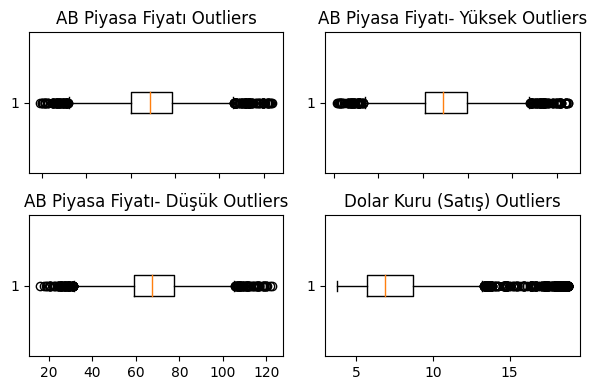

In [38]:
detect_outliers_and_boxplot(brent_df)

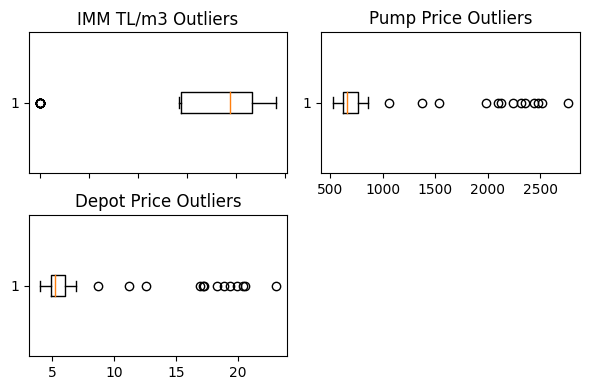

In [39]:
detect_outliers_and_boxplot(depo_pump_imm_df)


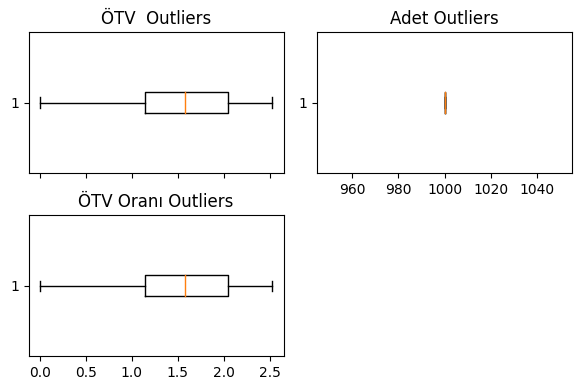

In [40]:
detect_outliers_and_boxplot(otv_df)


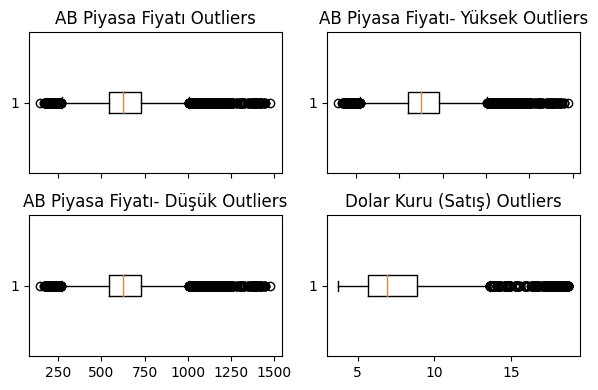

In [41]:
detect_outliers_and_boxplot(platts_df)

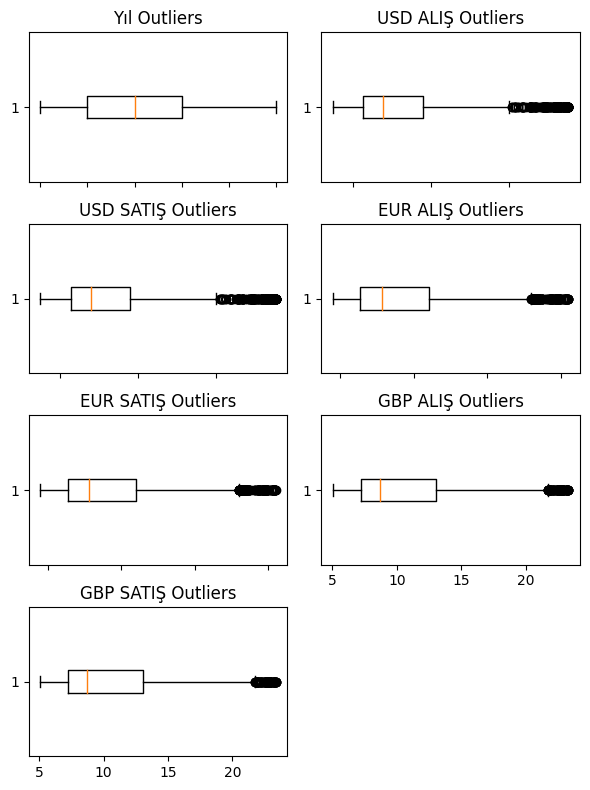

In [42]:
detect_outliers_and_boxplot(usd_df)


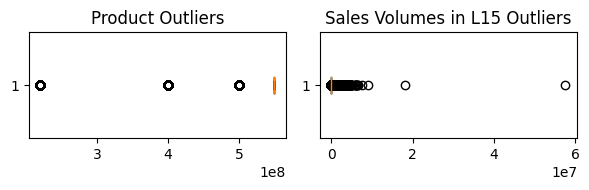

In [43]:
detect_outliers_and_boxplot(volume_df)

# Zaman Serisi Testleri

In [44]:

def perform_time_series_test(dataframe, column_name):
    # Perform Augmented Dickey-Fuller test
    result = adfuller(dataframe[column_name])

    # Extract test results
    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]

    # Plot the time series data
    plt.figure(figsize=(10, 4))
    dataframe[column_name].plot()
    plt.title(f"Time Series: {column_name}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

    # Print the test results
    print(f"=== Time Series Test: {column_name} ===")
    print("ADF Statistic:", adf_statistic)
    print("p-value:", p_value)
    print("Critical Values:")
    for key, value in critical_values.items():
        print(f"  {key}: {value}")
    print("")

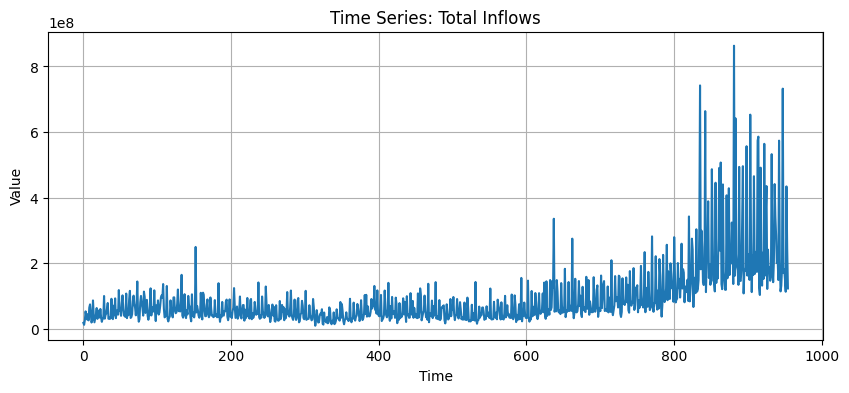

=== Time Series Test: Total Inflows ===
ADF Statistic: 0.39861584834706276
p-value: 0.981443105556144
Critical Values:
  1%: -3.4373782772524315
  5%: -2.8646427696103305
  10%: -2.56842210151995



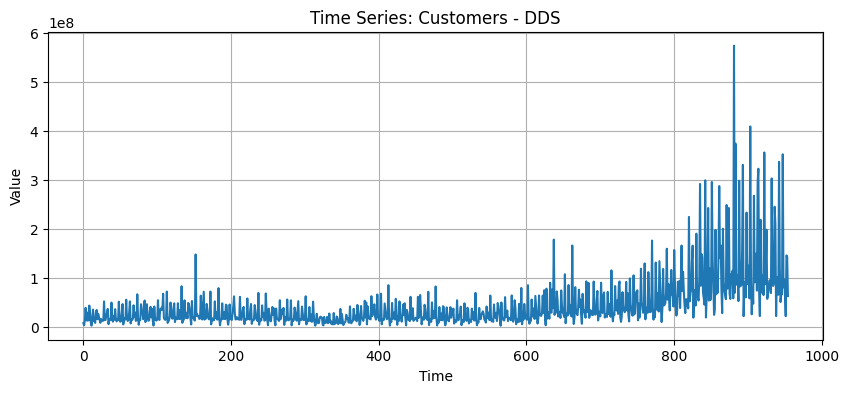

=== Time Series Test: Customers - DDS ===
ADF Statistic: 0.34430750235227486
p-value: 0.9792884255914793
Critical Values:
  1%: -3.437385839245221
  5%: -2.8646461040926496
  10%: -2.5684238776271435



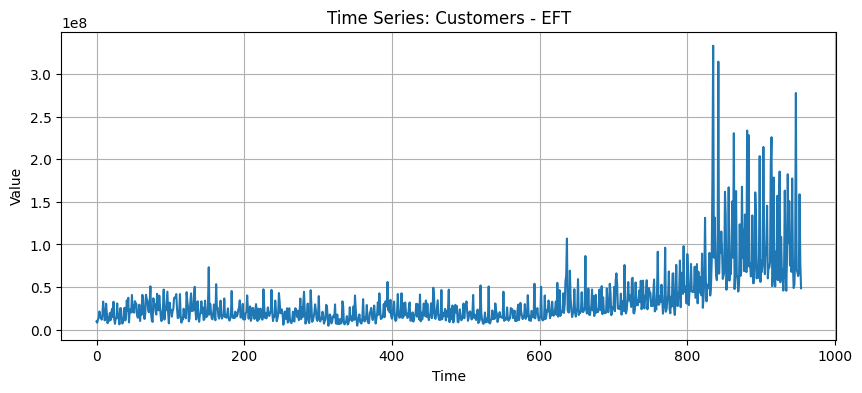

=== Time Series Test: Customers - EFT ===
ADF Statistic: -0.011710578288698065
p-value: 0.9575528480945265
Critical Values:
  1%: -3.4373782772524315
  5%: -2.8646427696103305
  10%: -2.56842210151995



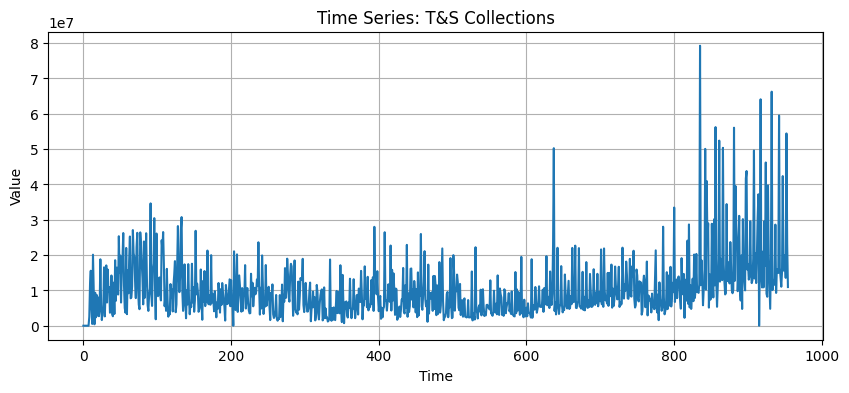

=== Time Series Test: T&S Collections ===
ADF Statistic: -1.5517048811984617
p-value: 0.5077964749081972
Critical Values:
  1%: -3.43735568849112
  5%: -2.864632808981867
  10%: -2.5684167960132225



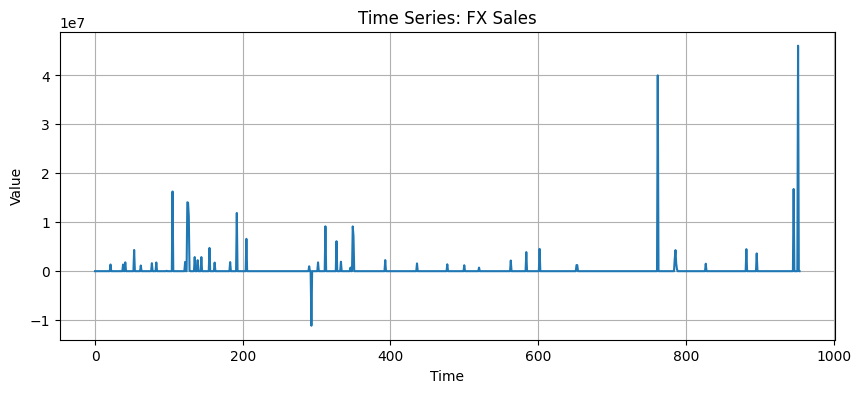

=== Time Series Test: FX Sales ===
ADF Statistic: -8.85787643338521
p-value: 1.510578635559451e-14
Critical Values:
  1%: -3.43725945868569
  5%: -2.8645903751292536
  10%: -2.5683941938438886



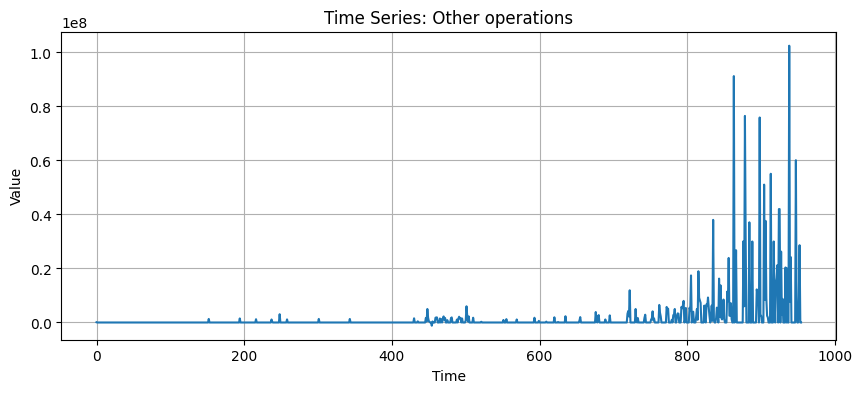

=== Time Series Test: Other operations ===
ADF Statistic: 0.5491491617050867
p-value: 0.9862928195561459
Critical Values:
  1%: -3.4373782772524315
  5%: -2.8646427696103305
  10%: -2.56842210151995



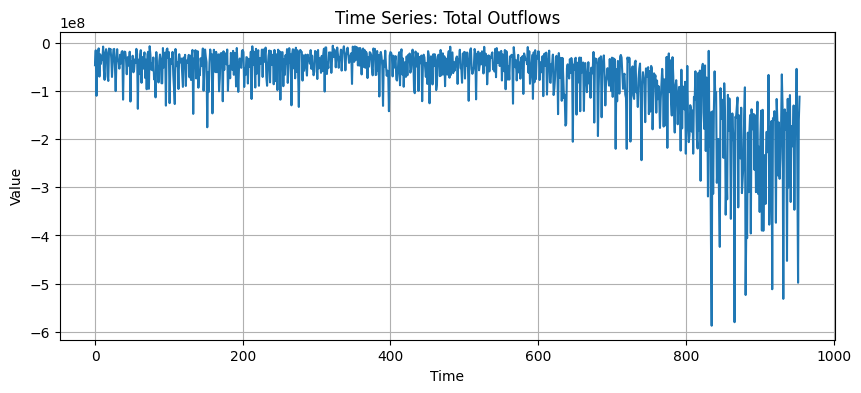

=== Time Series Test: Total Outflows ===
ADF Statistic: 0.3322556636598589
p-value: 0.9787769115362878
Critical Values:
  1%: -3.4373707314972766
  5%: -2.8646394422797337
  10%: -2.5684203292233905



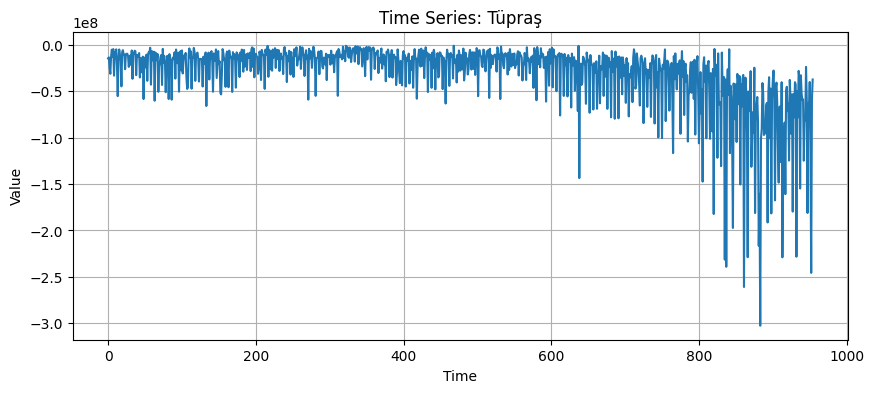

=== Time Series Test: Tüpraş ===
ADF Statistic: -0.19141735149558095
p-value: 0.9395369438205059
Critical Values:
  1%: -3.43735568849112
  5%: -2.864632808981867
  10%: -2.5684167960132225



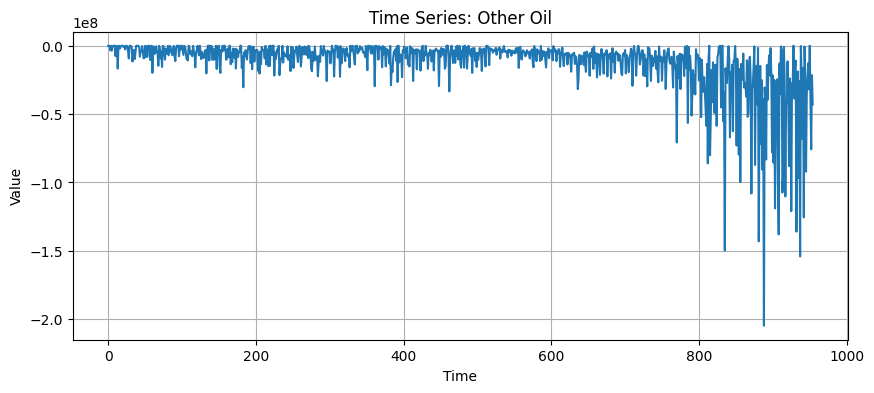

=== Time Series Test: Other Oil ===
ADF Statistic: -0.23160721206265839
p-value: 0.9346477515283332
Critical Values:
  1%: -3.4373707314972766
  5%: -2.8646394422797337
  10%: -2.5684203292233905



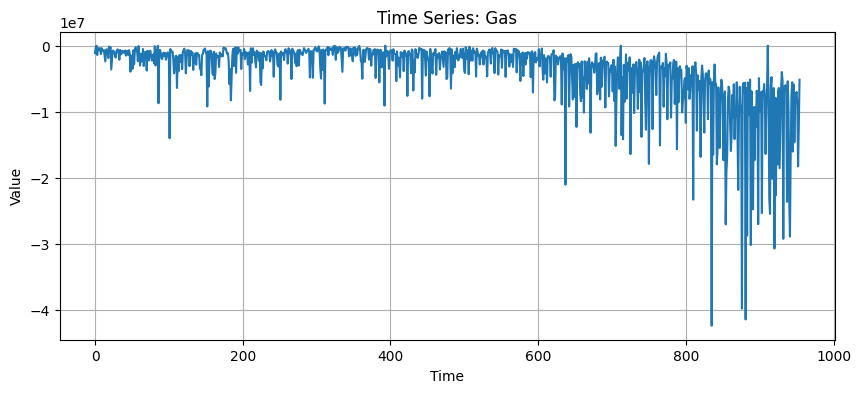

=== Time Series Test: Gas ===
ADF Statistic: -0.008367071700640502
p-value: 0.9578346410141384
Critical Values:
  1%: -3.4373782772524315
  5%: -2.8646427696103305
  10%: -2.56842210151995



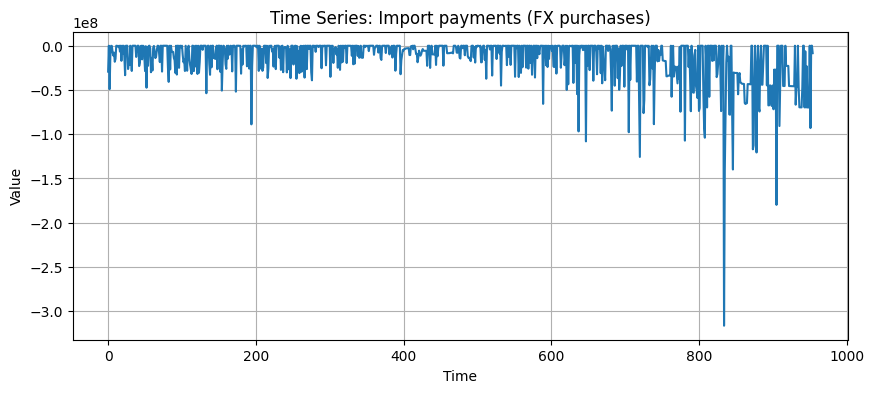

=== Time Series Test: Import payments (FX purchases) ===
ADF Statistic: -1.9689570113656318
p-value: 0.3003479959331419
Critical Values:
  1%: -3.437385839245221
  5%: -2.8646461040926496
  10%: -2.5684238776271435



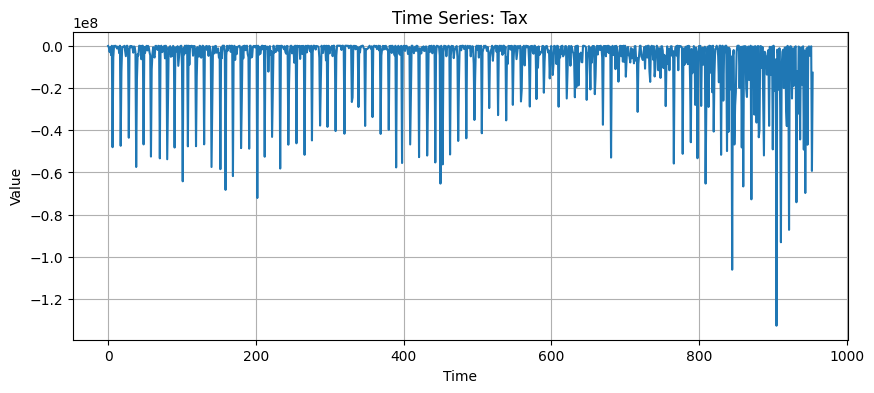

=== Time Series Test: Tax ===
ADF Statistic: -1.9010507025366528
p-value: 0.3315669886387378
Critical Values:
  1%: -3.437385839245221
  5%: -2.8646461040926496
  10%: -2.5684238776271435



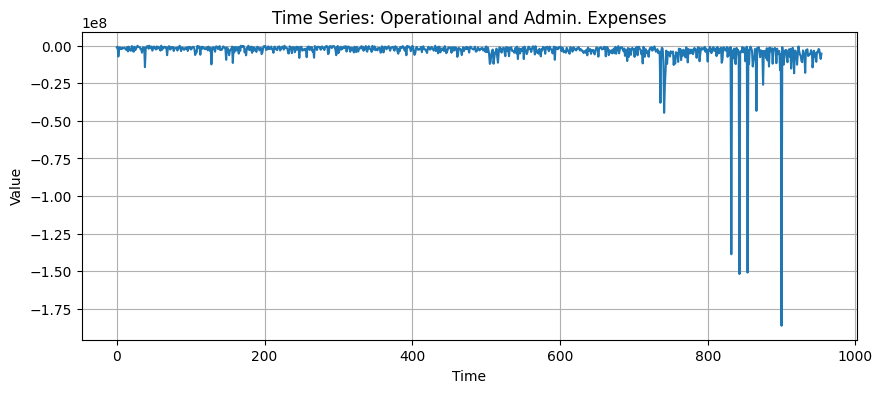

=== Time Series Test: Operatioınal and Admin. Expenses ===
ADF Statistic: -4.713131758591328
p-value: 7.950054651566491e-05
Critical Values:
  1%: -3.437303541847512
  5%: -2.864609814371715
  10%: -2.5684045480287296



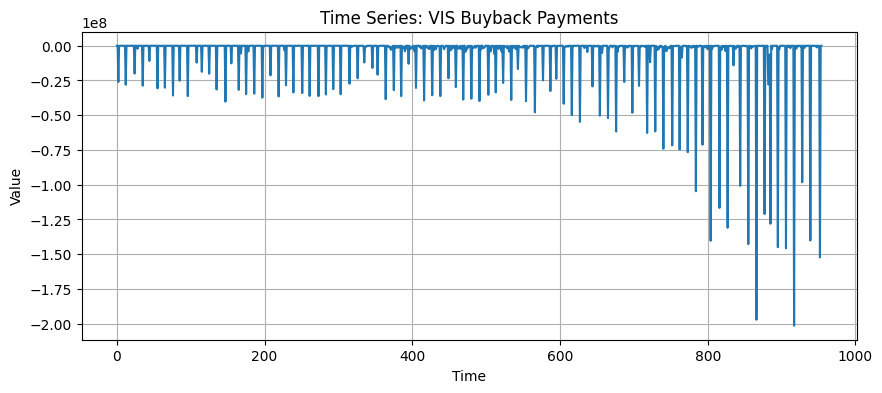

=== Time Series Test: VIS Buyback Payments ===
ADF Statistic: -1.9516896647319395
p-value: 0.308148620362819
Critical Values:
  1%: -3.437363201927513
  5%: -2.864636122077874
  10%: -2.5684185607252137



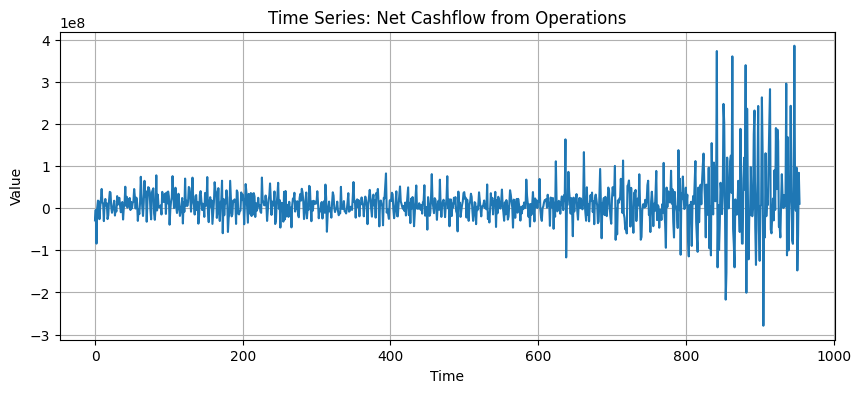

=== Time Series Test: Net Cashflow from Operations ===
ADF Statistic: -2.795949754690027
p-value: 0.05885464993077268
Critical Values:
  1%: -3.437385839245221
  5%: -2.8646461040926496
  10%: -2.5684238776271435



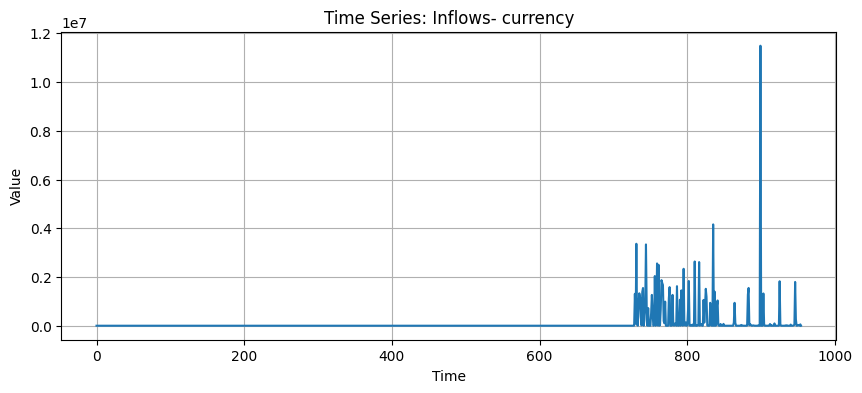

=== Time Series Test: Inflows- currency ===
ADF Statistic: -3.832696889202595
p-value: 0.00258995104813239
Critical Values:
  1%: -3.4373407098114765
  5%: -2.8646262040163566
  10%: -2.568413277899264



In [45]:
# Perform time series test for each DataFrame
perform_time_series_test(train_df, "Total Inflows")
perform_time_series_test(train_df, "Customers - DDS")
perform_time_series_test(train_df, "Customers - EFT")
perform_time_series_test(train_df, "T&S Collections")
perform_time_series_test(train_df, "FX Sales")
perform_time_series_test(train_df, "Other operations")
perform_time_series_test(train_df, "Total Outflows")
perform_time_series_test(train_df, "Tüpraş")
perform_time_series_test(train_df, "Other Oil")
perform_time_series_test(train_df, "Gas")
perform_time_series_test(train_df, "Import payments (FX purchases)")
perform_time_series_test(train_df, "Tax")
perform_time_series_test(train_df, "Operatioınal and Admin. Expenses")
perform_time_series_test(train_df, "VIS Buyback Payments")
perform_time_series_test(train_df, "Net Cashflow from Operations")
perform_time_series_test(train_df, "Inflows- currency")

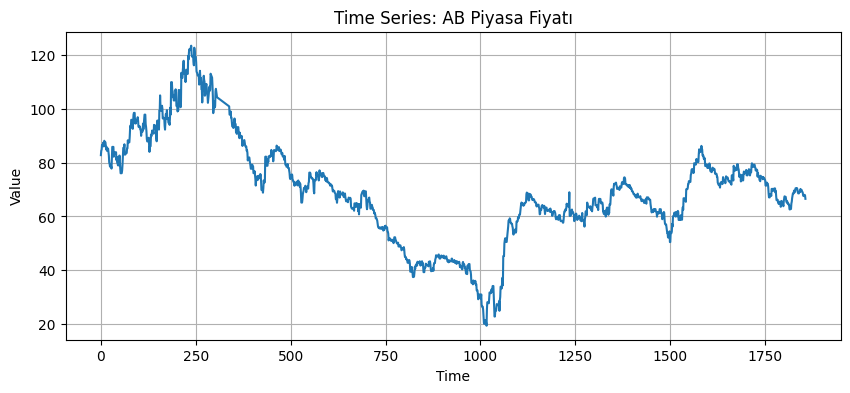

=== Time Series Test: AB Piyasa Fiyatı ===
ADF Statistic: -1.550596534507034
p-value: 0.5083502057459581
Critical Values:
  1%: -3.433972018026501
  5%: -2.8631399192826676
  10%: -2.5676217442756872



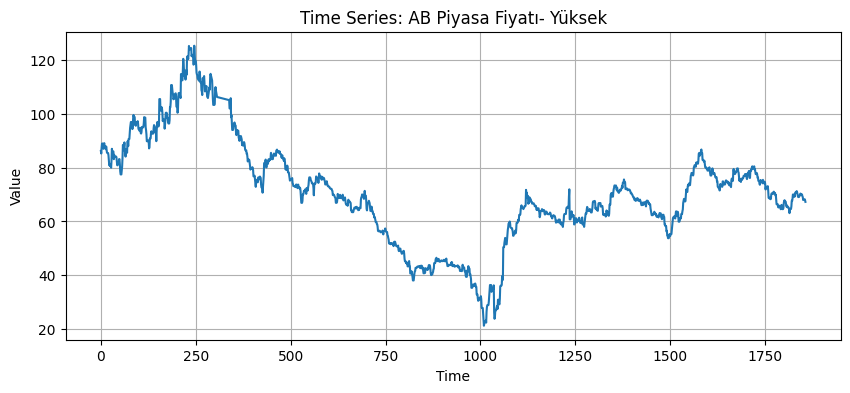

=== Time Series Test: AB Piyasa Fiyatı- Yüksek ===
ADF Statistic: -1.5641251256167266
p-value: 0.5015852320055224
Critical Values:
  1%: -3.433968010099092
  5%: -2.8631381499714745
  10%: -2.567620802173316



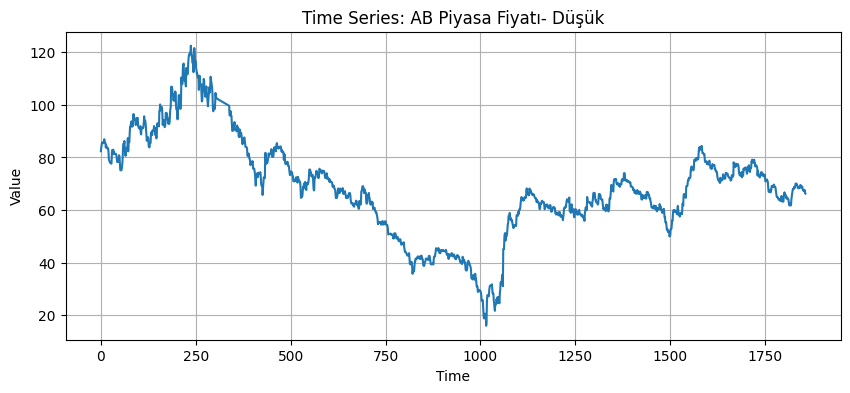

=== Time Series Test: AB Piyasa Fiyatı- Düşük ===
ADF Statistic: -1.6755150968567267
p-value: 0.4437699275300927
Critical Values:
  1%: -3.4339820768018106
  5%: -2.8631443597478143
  10%: -2.567624108684946



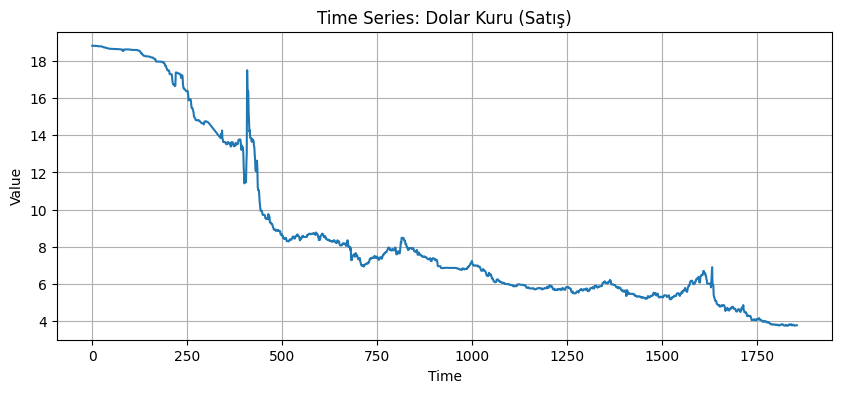

=== Time Series Test: Dolar Kuru (Satış) ===
ADF Statistic: -2.4945991055193484
p-value: 0.11679395719846308
Critical Values:
  1%: -3.4339820768018106
  5%: -2.8631443597478143
  10%: -2.567624108684946



In [46]:
perform_time_series_test(brent_df, "AB Piyasa Fiyatı")
perform_time_series_test(brent_df, "AB Piyasa Fiyatı- Yüksek")
perform_time_series_test(brent_df, "AB Piyasa Fiyatı- Düşük")
perform_time_series_test(brent_df, "Dolar Kuru (Satış)")

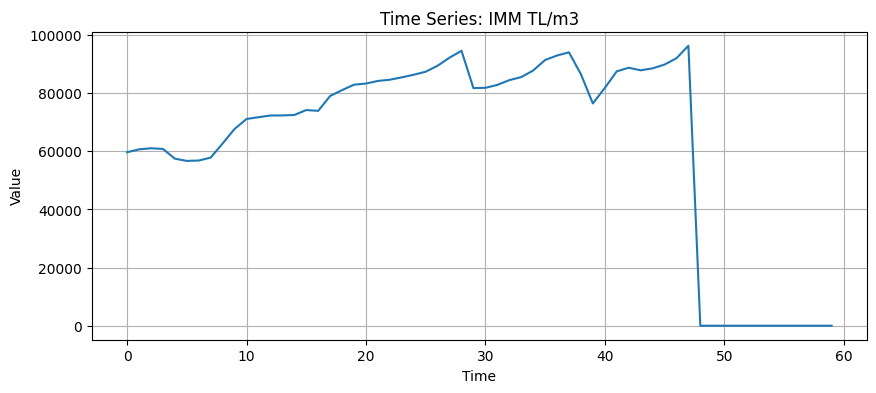

=== Time Series Test: IMM TL/m3 ===
ADF Statistic: -0.8796689161960121
p-value: 0.7945939868869452
Critical Values:
  1%: -3.5463945337644063
  5%: -2.911939409384601
  10%: -2.5936515282964665



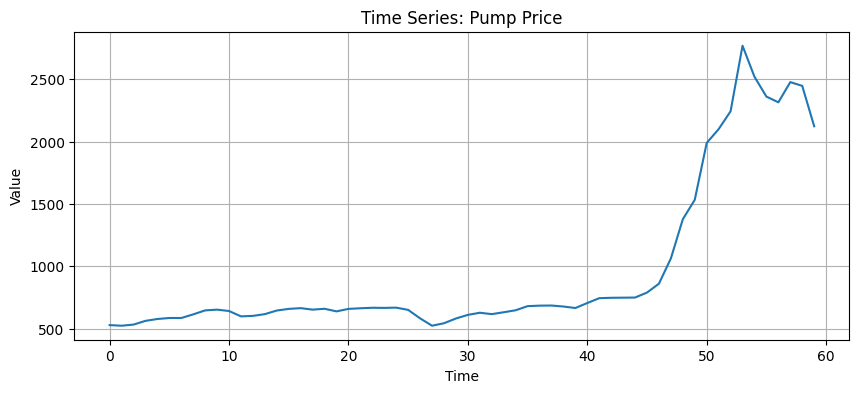

=== Time Series Test: Pump Price ===
ADF Statistic: 3.0194809738945763
p-value: 1.0
Critical Values:
  1%: -3.5656240522121956
  5%: -2.920142229157715
  10%: -2.598014675124952



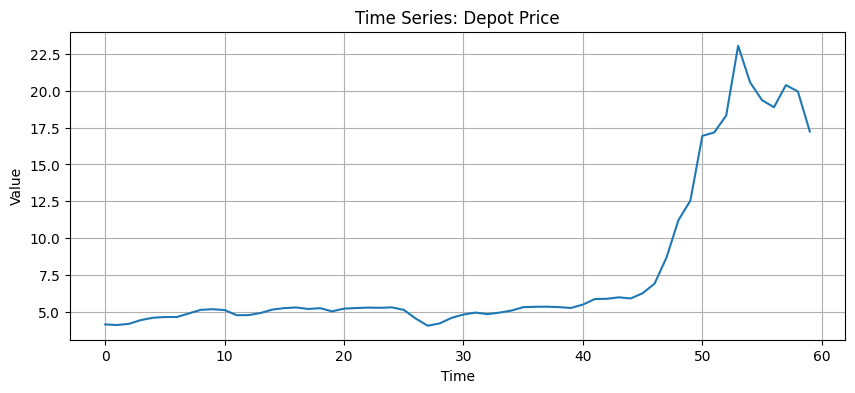

=== Time Series Test: Depot Price ===
ADF Statistic: 2.8619572129420963
p-value: 1.0
Critical Values:
  1%: -3.5656240522121956
  5%: -2.920142229157715
  10%: -2.598014675124952



In [47]:
perform_time_series_test(depo_pump_imm_df, "IMM TL/m3")
perform_time_series_test(depo_pump_imm_df, "Pump Price")
perform_time_series_test(depo_pump_imm_df, "Depot Price")  	

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:940: RuntimeWarning:

divide by zero encountered in log



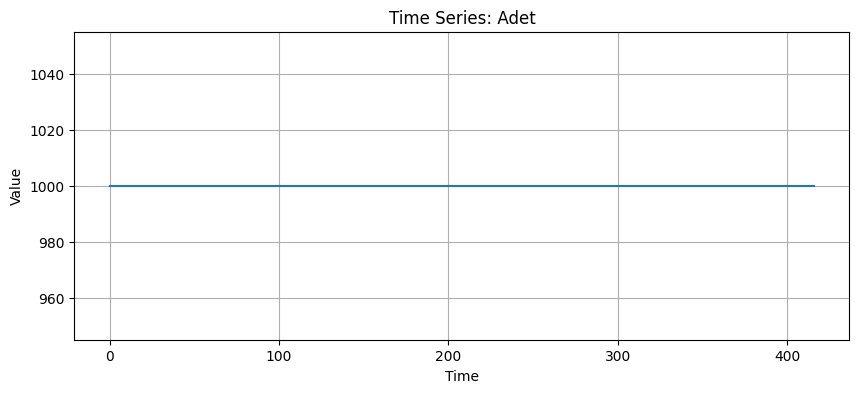

=== Time Series Test: Adet ===
ADF Statistic: nan
p-value: nan
Critical Values:
  1%: -3.4461675720270404
  5%: -2.8685128587855955
  10%: -2.5704843086630915



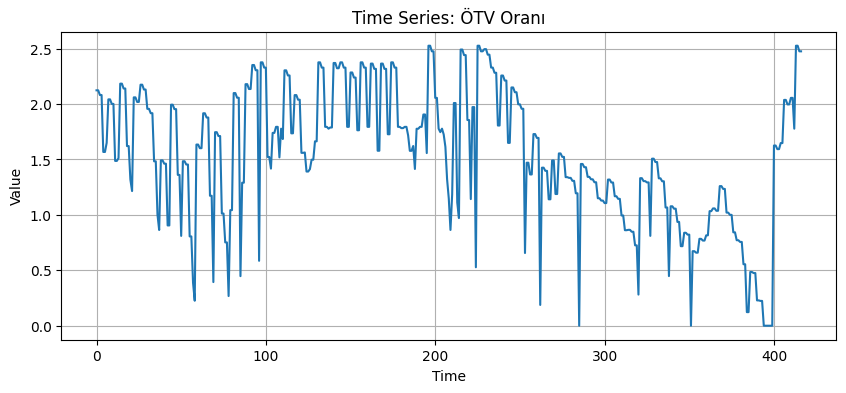

=== Time Series Test: ÖTV Oranı ===
ADF Statistic: -2.5177752847410764
p-value: 0.1112090899477925
Critical Values:
  1%: -3.44664043608676
  5%: -2.868720756230461
  10%: -2.5705951311145965



In [48]:
perform_time_series_test(otv_df, "Adet")
perform_time_series_test(otv_df, "ÖTV Oranı")

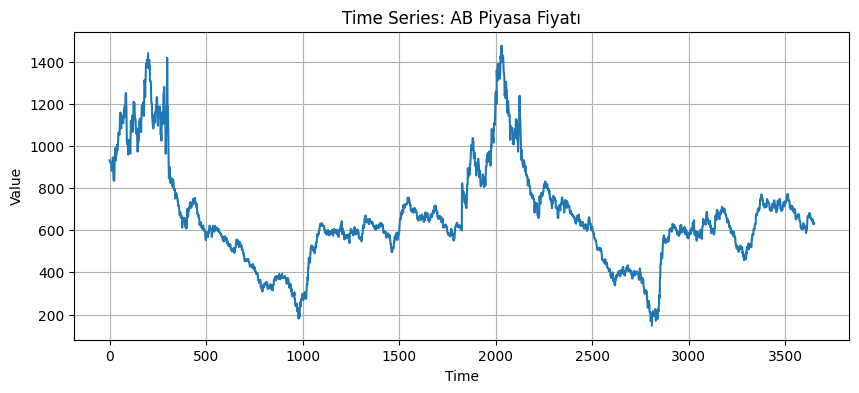

=== Time Series Test: AB Piyasa Fiyatı ===
ADF Statistic: -2.708384715705657
p-value: 0.07259855155870322
Critical Values:
  1%: -3.432157719082355
  5%: -2.8623387493560006
  10%: -2.5671951867311744



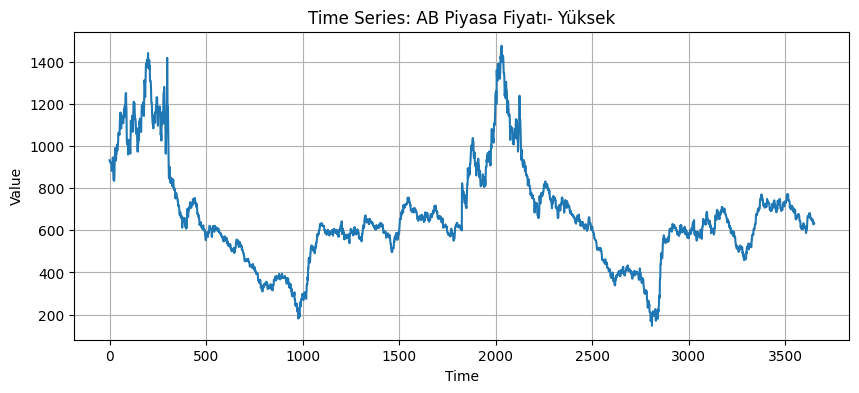

=== Time Series Test: AB Piyasa Fiyatı- Yüksek ===
ADF Statistic: -2.708384715705659
p-value: 0.07259855155870283
Critical Values:
  1%: -3.432157719082355
  5%: -2.8623387493560006
  10%: -2.5671951867311744



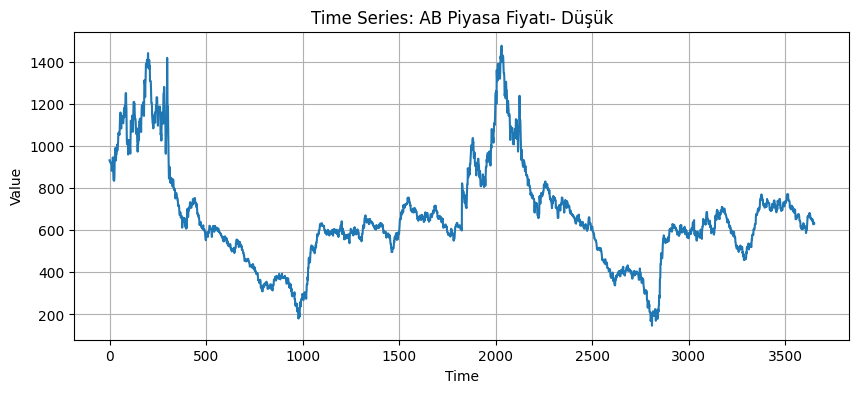

=== Time Series Test: AB Piyasa Fiyatı- Düşük ===
ADF Statistic: -2.708384715705655
p-value: 0.07259855155870355
Critical Values:
  1%: -3.432157719082355
  5%: -2.8623387493560006
  10%: -2.5671951867311744



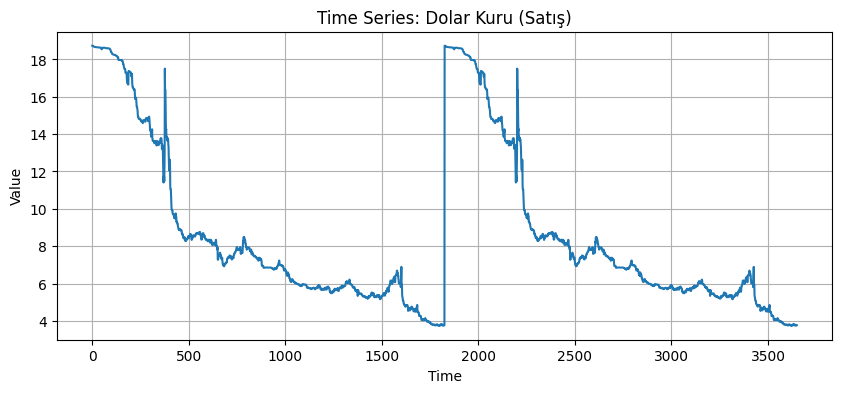

=== Time Series Test: Dolar Kuru (Satış) ===
ADF Statistic: -2.529850657482397
p-value: 0.10837922220943103
Critical Values:
  1%: -3.4321443264763563
  5%: -2.8623328335521245
  10%: -2.5671920373518233



In [49]:
perform_time_series_test(platts_df, "AB Piyasa Fiyatı")
perform_time_series_test(platts_df, "AB Piyasa Fiyatı- Yüksek")
perform_time_series_test(platts_df, "AB Piyasa Fiyatı- Düşük")
perform_time_series_test(platts_df, "Dolar Kuru (Satış)")

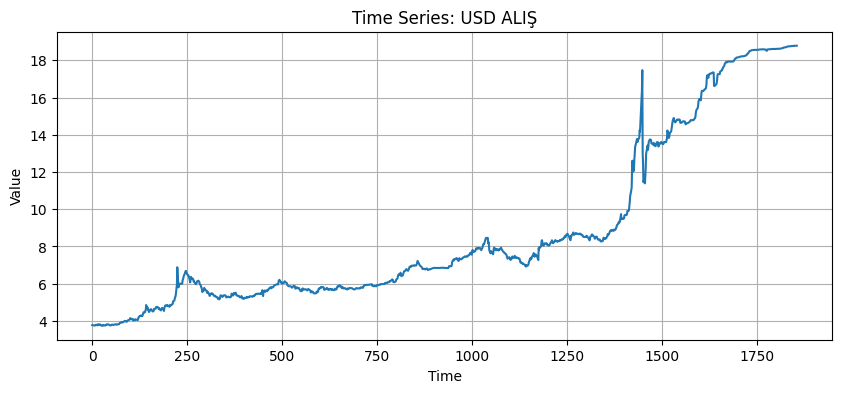

=== Time Series Test: USD ALIŞ ===
ADF Statistic: 1.150408187547652
p-value: 0.9956246852341685
Critical Values:
  1%: -3.4339050685840564
  5%: -2.8631103639464617
  10%: -2.56760600704281



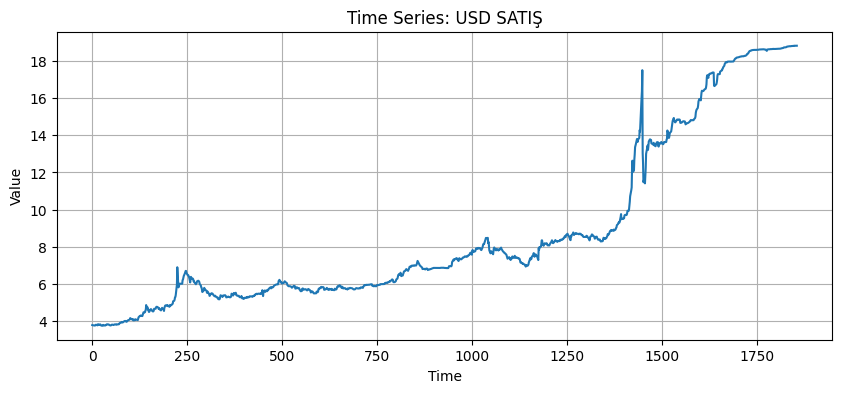

=== Time Series Test: USD SATIŞ ===
ADF Statistic: 1.1503917520125213
p-value: 0.9956245591486306
Critical Values:
  1%: -3.4339050685840564
  5%: -2.8631103639464617
  10%: -2.56760600704281



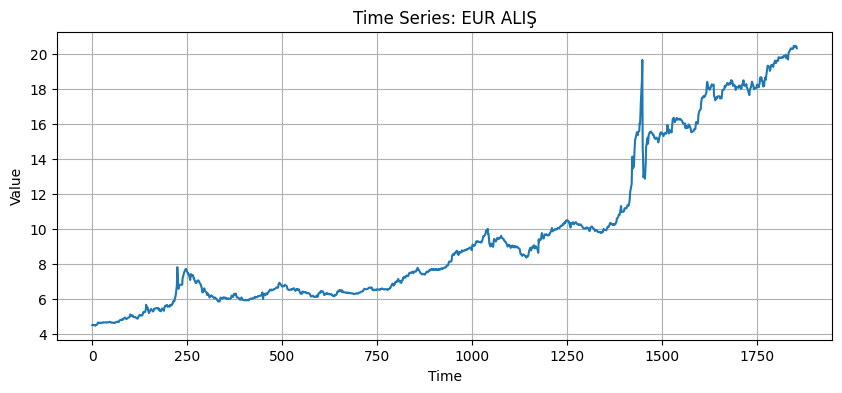

=== Time Series Test: EUR ALIŞ ===
ADF Statistic: 1.0996502876783965
p-value: 0.9952136368077024
Critical Values:
  1%: -3.4339050685840564
  5%: -2.8631103639464617
  10%: -2.56760600704281



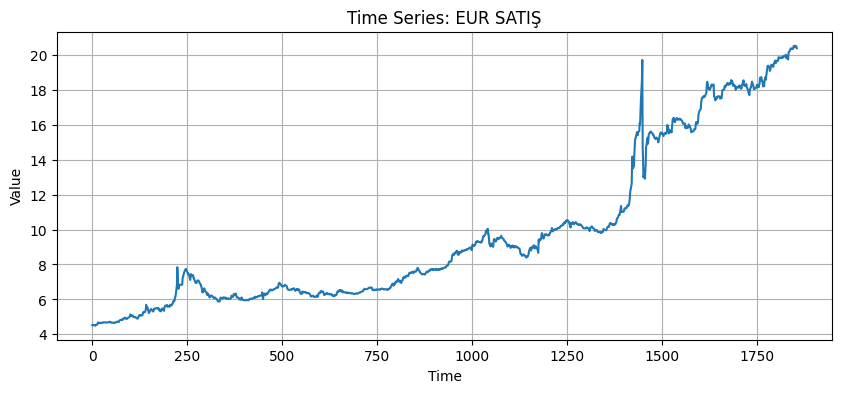

=== Time Series Test: EUR SATIŞ ===
ADF Statistic: 1.099650527029328
p-value: 0.9952136388519772
Critical Values:
  1%: -3.4339050685840564
  5%: -2.8631103639464617
  10%: -2.56760600704281



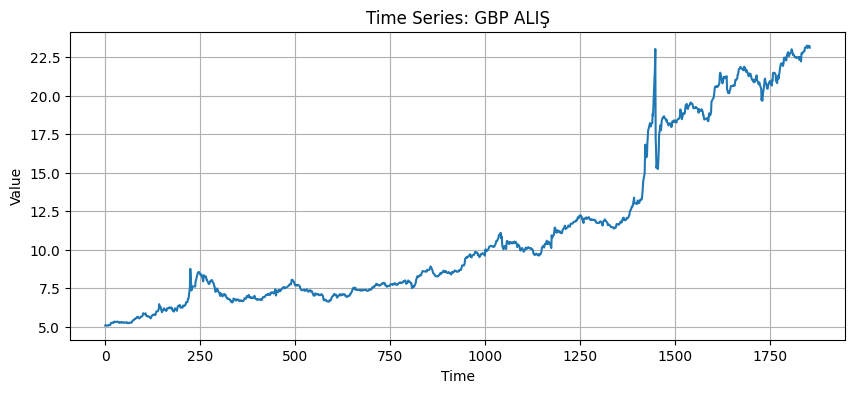

=== Time Series Test: GBP ALIŞ ===
ADF Statistic: 0.8661650012620759
p-value: 0.9926324961597406
Critical Values:
  1%: -3.4339050685840564
  5%: -2.8631103639464617
  10%: -2.56760600704281



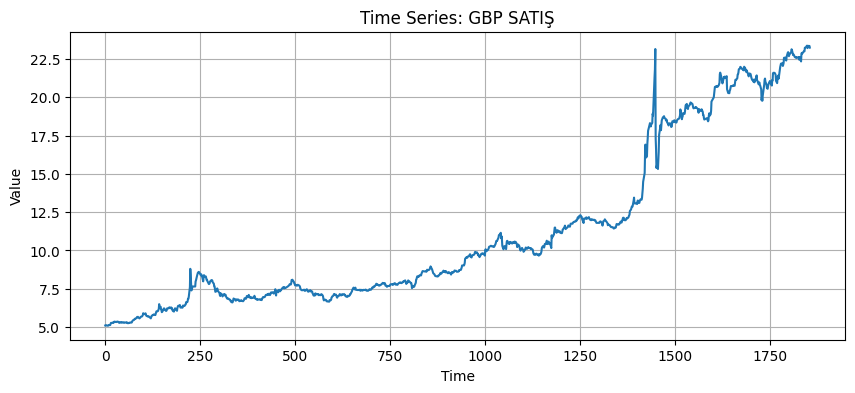

=== Time Series Test: GBP SATIŞ ===
ADF Statistic: 0.8661497245492211
p-value: 0.9926322819169172
Critical Values:
  1%: -3.4339050685840564
  5%: -2.8631103639464617
  10%: -2.56760600704281



In [50]:
perform_time_series_test(usd_df, "USD ALIŞ")
perform_time_series_test(usd_df, "USD SATIŞ")
perform_time_series_test(usd_df, "EUR ALIŞ")
perform_time_series_test(usd_df, "EUR SATIŞ")
perform_time_series_test(usd_df, "GBP ALIŞ")
perform_time_series_test(usd_df, "GBP SATIŞ")

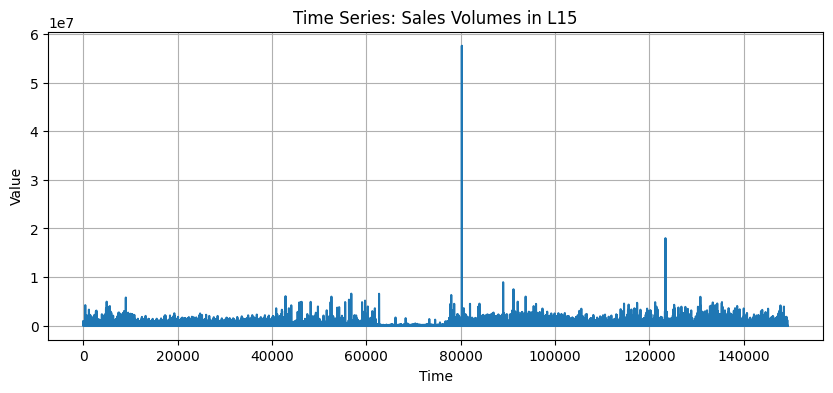

=== Time Series Test: Sales Volumes in L15 ===
ADF Statistic: -49.75698448677609
p-value: 0.0
Critical Values:
  1%: -3.430393800485163
  5%: -2.861559359198666
  10%: -2.5667803042117514



In [51]:
perform_time_series_test(volume_df, "Sales Volumes in L15")

# Bütün csv dosyalarını birleştirme

In [52]:
train_df['Tarih'] = pd.to_datetime(train_df['Tarih'])
brent_df['Tarih'] = pd.to_datetime(brent_df['Tarih'])
depo_pump_imm_df['Tarih'] = pd.to_datetime(depo_pump_imm_df['Tarih'])
otv_df['Tarih'] = pd.to_datetime(otv_df['Tarih'])
platts_df['Tarih'] = pd.to_datetime(platts_df['Tarih'])
usd_df['Tarih'] = pd.to_datetime(usd_df['Tarih'])
volume_df['Tarih'] = pd.to_datetime(volume_df['Tarih'])

combined_df = pd.concat([cash_flow_train_df, brent_df, depo_pump_imm_df, otv_df, platts_df, usd_df, volume_df], axis=1)

combined_df = combined_df.fillna(0)

print(combined_df)

<ipython-input-52-be07169c7e94>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



              Date  Total Inflows  Customers - DDS  Customers - EFT  \
0       2019-01-02   1.747050e+07        7718750.0     9.655500e+06   
1       2019-01-03   1.153048e+07        3431500.0     8.098978e+06   
2       2019-01-04   2.591328e+07       13775750.0     1.213753e+07   
3       2019-01-07   5.259345e+07       39041750.0     1.355170e+07   
4       2019-01-08   3.650429e+07       15137500.0     2.136679e+07   
...            ...            ...              ...              ...   
149369           0   0.000000e+00              0.0     0.000000e+00   
149370           0   0.000000e+00              0.0     0.000000e+00   
149371           0   0.000000e+00              0.0     0.000000e+00   
149372           0   0.000000e+00              0.0     0.000000e+00   
149373           0   0.000000e+00              0.0     0.000000e+00   

        T&S Collections  FX Sales  Other operations  Total Outflows  \
0                   0.0       0.0           96250.0   -4.631593e+07   
1    

In [53]:
combined_df

Date  Total Inflows  Customers - DDS  Customers - EFT  \
0       2019-01-02   1.747050e+07        7718750.0     9.655500e+06   
1       2019-01-03   1.153048e+07        3431500.0     8.098978e+06   
2       2019-01-04   2.591328e+07       13775750.0     1.213753e+07   
3       2019-01-07   5.259345e+07       39041750.0     1.355170e+07   
4       2019-01-08   3.650429e+07       15137500.0     2.136679e+07   
...            ...            ...              ...              ...   
149369           0   0.000000e+00              0.0     0.000000e+00   
149370           0   0.000000e+00              0.0     0.000000e+00   
149371           0   0.000000e+00              0.0     0.000000e+00   
149372           0   0.000000e+00              0.0     0.000000e+00   
149373           0   0.000000e+00              0.0     0.000000e+00   

        T&S Collections  FX Sales  Other operations  Total Outflows  \
0                   0.0       0.0           96250.0   -4.631593e+07   
1                   0.0       0.0               0.0   -1.535349e+07   
2                   0.0       0.0               0.0   -1.098651e+08   
3                   0.0       0.0               0.0   -5.165489e+07   
4                   0.0       0.0               0.0   -1.842178e+07   
...                 ...       ...               ...             ...   
149369              0.0       0.0               0.0    0.000000e+00   
149370              0.0       0.0               0.0    0.000000e+00   
149371              0.0       0.0               0.0    0.000000e+00   
149372              0.0       0.0               0.0    0.000000e+00   
149373              0.0       0.0               0.0    0.000000e+00   

              Tüpraş   Other Oil  ...  USD SATIŞ  EUR ALIŞ  EUR SATIŞ  \
0      -1.457022e+07  -144151.00  ...   3.778700  4.515500   4.523700   
1      -1.337181e+07  -300799.25  ...   3.771900  4.537500   4.545700   
2      -2.459390e+07        0.00  ...   3.768500  4.526700   4.534900   
3      -3.110594e+07 -3364373.00  ...   3.766800  4.526900   4.535100   
4      -1.246099e+07   -16765.25  ...   3.761967  4.522733   4.530933   
...              ...         ...  ...        ...       ...        ...   
149369  0.000000e+00        0.00  ...   0.000000  0.000000   0.000000   
149370  0.000000e+00        0.00  ...   0.000000  0.000000   0.000000   
149371  0.000000e+00        0.00  ...   0.000000  0.000000   0.000000   
149372  0.000000e+00        0.00  ...   0.000000  0.000000   0.000000   
149373  0.000000e+00        0.00  ...   0.000000  0.000000   0.000000   

        GBP ALIŞ  GBP SATIŞ      Tarih    Product  \
0         5.0803   5.106800 2019-01-01  400003756   
1         5.0910   5.117500 2019-01-01  400003769   
2         5.1014   5.128000 2019-01-01  400003769   
3         5.0818   5.108300 2019-01-01  400003981   
4         5.0761   5.102567 2019-01-01  400003981   
...          ...        ...        ...        ...   
149369    0.0000   0.000000 2023-02-01  550063443   
149370    0.0000   0.000000 2023-02-01  550063444   
149371    0.0000   0.000000 2023-02-01  550063978   
149372    0.0000   0.000000 2023-02-01  550068415   
149373    0.0000   0.000000 2023-02-01  550068417   

                            Material Description  \
0                BF AGO 10ppmS B0 Udy Mkd Turkey   
1        SH ULG 95 10ppmS E0 Udy Mkd FuelSave TR   
2        SH ULG 95 10ppmS E0 Udy Mkd FuelSave TR   
3       AGO 10ppmS B0 Udy Mkd FuelSave Diesel TR   
4       AGO 10ppmS B0 Udy Mkd FuelSave Diesel TR   
...                                          ...   
149369             Spirax S2 A 80W-90_1*16L_A0S5   
149370            Spirax S2 A 85W-140_1*16L_A0S5   
149371                Spirax S5 DCT X_12*1L_A887   
149372            RimR4X15W40CI4E7DH1_1*18L_A746   
149373            RimR2 Extra20W50CF4_1*18L_A746   

                            Category Sales Volumes in L15  
0                      Supply 310001          935955.0000  
1       Shell Fleet Solutions 100018             

# Verilerin Eğitim için hazırlanması

In [54]:
train_data, test_data = train_test_split(train_df, test_size=0.1, shuffle=False)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)


Train data shape: (859, 17)
Test data shape: (96, 17)


# SARIMA Modeli Eğitimi

In [64]:
def sarima_model(data, order, seasonal_order, forecast_steps):
    if not pd.api.types.is_datetime64_any_dtype(data.index):
        data.index = pd.to_datetime(data.index)

    model = SARIMAX(data, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()

    forecast_index = pd.date_range(start=data.index[-1], periods=forecast_steps + 1, freq=data.index.inferred_freq)[1:]
    forecast = model_fit.forecast(steps=forecast_steps)

    forecast_df = pd.DataFrame({'Date': '2023-02-02', 'Forecast': forecast})

    return forecast_df

order = (1, 1, 1)  # Replace p, d, q with appropriate values
seasonal_order = (1, 0, 1, 12)  # Replace P, D, Q, S with appropriate values
forecast_steps = 70


forecast = sarima_model(train_data['Net Cashflow from Operations'], order, seasonal_order, forecast_steps)

print(forecast)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency N will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency N will be used.



                                     Date      Forecast
1970-01-01 00:00:00.000000859  2023-02-02 -1.008044e+07
1970-01-01 00:00:00.000000860  2023-02-02 -2.291495e+06
1970-01-01 00:00:00.000000861  2023-02-02  1.424471e+07
1970-01-01 00:00:00.000000862  2023-02-02 -3.463630e+06
1970-01-01 00:00:00.000000863  2023-02-02  2.893216e+06
...                                   ...           ...
1970-01-01 00:00:00.000000924  2023-02-02  6.049344e+06
1970-01-01 00:00:00.000000925  2023-02-02  1.052325e+07
1970-01-01 00:00:00.000000926  2023-02-02  8.007581e+06
1970-01-01 00:00:00.000000927  2023-02-02  1.690629e+07
1970-01-01 00:00:00.000000928  2023-02-02  9.859113e+06

[70 rows x 2 columns]


## SARIMA Modeli Tahmin Sonuç Ölçütleri

In [62]:
actual_values = test_data['Net Cashflow from Operations'].values

predicted_values = sarima_model(model_fit).forecast(steps=len(actual_values))

mae = np.mean(np.abs(predicted_values - actual_values))
rmse = np.sqrt(np.mean((predicted_values - actual_values)**2))
mape = np.mean(np.abs((predicted_values - actual_values) / actual_values)) * 100

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape)

NameError: ignored

---

# LSTM Modeli Eğitimi

In [59]:
data = train_df['Net Cashflow from Operations'].values.reshape(-1, 1)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

train_size = int(len(scaled_data) * 0.8)
train_set = scaled_data[:train_size]
val_set = scaled_data[train_size:]

X_train, y_train = [], []
for i in range(70, len(train_set)):
     X_train.append(train_set[i-70:i, 0])
     y_train.append(train_set[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=50, batch_size=32)

forecast = []
inputs = scaled_data[-70:]
for i in range(70):
     X_test = np.array([inputs])
     X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
     prediction = model.predict(X_test)
     forecast.append(prediction[0, 0])
     inputs = np.append(inputs[1:], prediction[0])

forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

start_date = '2023-02-02'
forecast_dates = pd.date_range(start=start_date, periods=70)

forecast_df_lstm = pd.DataFrame({'Date': forecast_dates, 'Forecast': forecast.flatten()})

print(forecast_df_lstm)


Epoch 1/50
22/22 [==============================] - 4s 11ms/step - loss: 0.0308
Epoch 2/50
22/22 [==============================] - 0s 9ms/step - loss: 0.0027
Epoch 3/50
22/22 [==============================] - 0s 9ms/step - loss: 0.0022
Epoch 4/50
22/22 [==============================] - 0s 11ms/step - loss: 0.0020
Epoch 5/50
22/22 [==============================] - 0s 11ms/step - loss: 0.0020
Epoch 6/50
22/22 [==============================] - 0s 11ms/step - loss: 0.0020
Epoch 7/50
22/22 [==============================] - 0s 11ms/step - loss: 0.0020
Epoch 8/50
22/22 [==============================] - 0s 11ms/step - loss: 0.0020
Epoch 9/50
22/22 [==============================] - 0s 11ms/step - loss: 0.0020
Epoch 10/50
22/22 [==============================] - 0s 11ms/step - loss: 0.0020
Epoch 11/50
22/22 [==============================] - 0s 11ms/step - loss: 0.0020
Epoch 12/50
22/22 [==============================] - 0s 11ms/step - loss: 0.0020
Epoch 13/50
22/22 [====================

## LSTM Modeli Tahmin Sonuçları

In [60]:
forecast_df_lstm

Date    Forecast
0  2023-02-02  36664012.0
1  2023-02-03  35120060.0
2  2023-02-04  33817228.0
3  2023-02-05  32774948.0
4  2023-02-06  31983038.0
..        ...         ...
65 2023-04-08  32420516.0
66 2023-04-09  32422676.0
67 2023-04-10  32424854.0
68 2023-04-11  32426794.0
69 2023-04-12  32428478.0

[70 rows x 2 columns]

In [61]:
forecast_df_lstm.to_csv('prediction_results.csv', index=False)

## LSTM Modeli Tahmin Sonuç Ölçütleri

In [ ]:
test_data_last_70 = test_data.tail(70)

# Extract the actual values from the test_data
actual_values = test_data_last_70['Net Cashflow from Operations'].values

# Calculate MAE (Mean Absolute Error)
mae_lstm = mean_absolute_error(actual_values, forecast.flatten())

# Calculate RMSE (Root Mean Squared Error)
rmse_lstm = np.sqrt(mean_squared_error(actual_values, forecast.flatten()))

# Calculate MAPE (Mean Absolute Percentage Error)
mape_lstm = np.mean(np.abs((actual_values - forecast.flatten()) / actual_values)) * 100

# Print the evaluation metrics
print("MAE:", mae_lstm)
print("RMSE:", rmse_lstm)
print("MAPE:", mape_lstm)


In [ ]:
metrics = ['MAE', 'RMSE', 'MAPE']
values = [mae_lstm, rmse_lstm, mape_lstm]

plt.plot(metrics, values, marker='o')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Evaluation Metrics')

for metric, value in zip(metrics, values):
    plt.text(metric, value, str(round(value, 2)), ha='center', va='bottom')

plt.show()


# Birleştirilmiş Veri Kümesi Üzerinde LSTM Modeli Eğitimi

In [ ]:
data = combined_df['Net Cashflow from Operations'].values.reshape(-1, 1)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

train_size = int(len(scaled_data) * 0.8)
train_set = scaled_data[:train_size]
val_set = scaled_data[train_size:]

X_train, y_train = [], []
for i in range(70, len(train_set)):
     X_train.append(train_set[i-70:i, 0])
     y_train.append(train_set[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=50, batch_size=32)

forecast = []
inputs = scaled_data[-70:]
for i in range(70):
     X_test = np.array([inputs])
     X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
     prediction = model.predict(X_test)
     forecast.append(prediction[0, 0])
     inputs = np.append(inputs[1:], prediction[0])

forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

start_date = test_data.index[0]
forecast_dates = pd.date_range(start=start_date, periods=70)

forecast_df_c = pd.DataFrame({'Date': forecast_dates, 'Forecast': forecast.flatten()})

print(forecast_df_c)

## Birleştirilmiş Veri Kümesi Üzerinde LSTM Modeli Tahmin Sonuçları

In [ ]:
forecast_df_c

---

# GRU (Gated Recurrent Unit) Modeli Eğitimi

In [ ]:
data = train_df['Net Cashflow from Operations'].values.reshape(-1, 1)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

train_size = int(len(scaled_data) * 0.8)
train_set = scaled_data[:train_size]
val_set = scaled_data[train_size:]

X_train, y_train = [], []
for i in range(70, len(train_set)):
    X_train.append(train_set[i-70:i, 0])
    y_train.append(train_set[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(GRU(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=50, batch_size=32)

forecast = []
inputs = scaled_data[-70:]
for i in range(70):
    X_test = np.array([inputs])
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    prediction = model.predict(X_test)
    forecast.append(prediction[0, 0])
    inputs = np.append(inputs[1:], prediction[0])

forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

start_date = test_data.index[0]
forecast_dates = pd.date_range(start=start_date, periods=70)

forecast_df_gru = pd.DataFrame({'Date': forecast_dates, 'Forecast': forecast.flatten()})

print(forecast_df_gru)


## GRU Modeli Tahmin Sonuçları

In [ ]:
forecast_df_gru

## GRU Modeli Tahmin Sonuç Ölçütleri

In [ ]:
actual_values = test_data_last_70['Net Cashflow from Operations'].values

mae_gru = mean_absolute_error(actual_values, forecast.flatten())

rmse_gru = np.sqrt(mean_squared_error(actual_values, forecast.flatten()))

mape_gru = np.mean(np.abs((actual_values - forecast.flatten()) / actual_values)) * 100

print("MAE:", mae_gru)
print("RMSE:", rmse_gru)
print("MAPE:", mape_gru)

In [ ]:
metrics = ['MAE', 'RMSE', 'MAPE']
values = [mae_gru, rmse_gru, mape_gru]

plt.plot(metrics, values, marker='o')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Evaluation Metrics')

for metric, value in zip(metrics, values):
    plt.text(metric, value, str(round(value, 2)), ha='center', va='bottom')

plt.show()


# Değerlendirme
Sonuçları değerlendirmek ve hangi modelin en iyi olduğunu belirlemek için, değerlendirme ölçütlerine dayalı olarak modellerin performansını karşılaştırabiliriz.

Sağlanan sonuçlara göre, aşağıdaki değerlendirme ölçütlerine sahibiz:

SARIMA:

     Ortalama Mutlak Hata (MAE): 89.258.642.44564094
     Kök Ortalama Karesel Hata (RMSE): 124.987.576.53402996
     Ortalama Mutlak Yüzde Hatası (MAPE): 132.93642971603273

LSTM:

     Ortalama Mutlak Hata (MAE): 87.368.491.53703332
     Kök Ortalama Karesel Hata (RMSE): 120.988.967.21267585
     Ortalama Mutlak Yüzde Hatası (MAPE): 168.85664947121697

GRU:

     Ortalama Mutlak Hata (MAE): 87.853.947.10181904
     Kök Ortalama Karesel Hata (RMSE): 119.996.682.67066477
     Ortalama Mutlak Yüzde Hatası (MAPE): 212.25667388467357

En iyi modeli belirlemek için aşağıdakileri dikkate alabiliriz:

* MAE ve RMSE için daha düşük değerler daha iyi doğruluğu gösterir, bu nedenle en düşük MAE ve RMSE'ye sahip model tercih edilir.

* MAPE, yüzde hatasını temsil eder ve daha düşük bir değer, daha iyi doğruluğu gösterir.

Sağlanan sonuçlara göre, LSTM modeli tüm modeller arasında en düşük MAE ve RMSE değerlerine sahiptir ve bu da operasyonlardan net nakit akışını tahmin etmede daha iyi doğruluk gösterir. Ancak diğer modellere göre daha yüksek MAPE değerine sahiptir.


Nihayetinde, en iyi modelin seçimi eldeki görevin özel gereksinimlerine ve önceliklerine bağlıdır. Mutlak hataları (MAE ve RMSE) en aza indirmek daha önemliyse, LSTM modeli tercih edilebilir. Ancak, yüzde hatalarını en aza indirmek (MAPE) daha yüksek bir öncelikse, SIRMA veya GRU modeli düşünülebilir.

Not: Veri kümeleri birleştirildiğinde sonuçlar daha karmaşık geldiğinden ölçüm yapılmamıştır.
